In [1]:
from read_json import *
from spectrum_integrate import *
from plots import *
from source_filter import *
from variability_estimator import *

In [2]:
## main imports
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

## astro imports
import astropy.table
from astropy import units as u
from astropy.io import fits
from astropy.io import ascii
from astropy.table import QTable, Table

# from astropy.time import Time,TimeUnix
# from datetime import datetime

## other imports
import os
import csv
# import glob
# import math
# import json
# import statistics

# import scipy.optimize as sp
# import scipy.odr.odrpack as odrpack
# from scipy import signal, integrate
# from scipy.fft import fft, fftfreq
# from scipy.stats import pearsonr

# import matplotlib.ticker as mticker
# from matplotlib.ticker import FormatStrFormatter

Let's first import the 4LAC DR3 catalog.

In [3]:
path_4lac_dr3_catalog = '../4LAC_catalog_generator_v3/resulting_catalogs/agn_pop_4lac_dr3.ecsv'

table_agn_pop_4lac_dr3 = astropy.table.Table.read(path_4lac_dr3_catalog, format='ascii.ecsv')
df_agn_pop_4lac_dr3 = table_agn_pop_4lac_dr3.to_pandas()

In [4]:
df_agn_pop_4lac_dr3.head()

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000
0,J0001.2+4741,0.3126,47.685902,-inf,PowerLaw,2420.575195,2.156031e-14,2.271696,2.196550e-14,2.254081,0.012156,bcu,ISP,25.313953,0.675882,0.312850,1.259796e-10,2.877197e-11
1,J0001.2-0747,0.3151,-7.797100,-inf,PowerLaw,1721.603882,2.656894e-13,2.116692,2.842831e-13,2.078927,0.051182,bll,LSP,46.780693,0.406565,0.111870,7.471219e-10,5.041939e-11
2,J0001.4-0010,0.3717,-0.169900,0.461516,PowerLaw,4307.082520,6.067356e-15,1.939160,6.488817e-15,1.661223,0.132438,bll,LSP,9.272764,0.000000,10.000000,1.082246e-10,2.914440e-11
3,J0001.5+2113,0.3815,21.218300,1.106000,LogParabola,329.773743,4.683598e-11,2.654060,5.371562e-11,2.514159,0.159319,fsrq,ISP,1910.935791,0.996138,0.213478,1.347354e-09,6.172809e-11
4,J0001.6-4156,0.4165,-41.942501,-inf,PowerLaw,4047.030029,1.881541e-14,1.775175,2.131597e-14,1.693865,0.072754,bcu,HSP,26.393343,0.490977,0.175782,2.821817e-10,3.090882e-11


The table above contains information about the Source Spectrum, but not it's whole integrated flux.
Let's estimate the integrated flux from each source's spectrum.

Note that Flux1000 only has values of this Spectrum from 1-100 GeV, which can be used as a cross-check for the way we estimate the Spectrum_Flux, but we have the lightcurves in the range 0.1-100 GeV!

In [5]:
spectrum_flux_values = []

for row in table_agn_pop_4lac_dr3:

    source_name = row['Source_Name']
    
    ## integrate from 0.1-100 GeV
    spectrum_flux, diff_flux, spec_type = integrate_spectrum_flux(source_name, df_agn_pop_4lac_dr3, 0.1, 100)
    
    spectrum_flux_values.append(spectrum_flux)

table_agn_pop_4lac_dr3['Spectrum_Flux_Estimated'] = spectrum_flux_values

/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/spectrum_integrate.py:71: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  flux_from_spectrum = integrate.quad(lambda x: K * ((x/E_0)**(- alpha - beta * np.log(x/E_0))),


In [6]:
df_agn_pop_4lac_dr3 = table_agn_pop_4lac_dr3.to_pandas()

In [7]:
df_agn_pop_4lac_dr3

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated
0,J0001.2+4741,0.312600,47.685902,-inf,PowerLaw,2420.575195,2.156031e-14,2.271696,2.196550e-14,2.254081,0.012156,bcu,ISP,25.313953,0.675882,0.312850,1.259796e-10,2.877197e-11,1.993321e-09
1,J0001.2-0747,0.315100,-7.797100,-inf,PowerLaw,1721.603882,2.656894e-13,2.116692,2.842831e-13,2.078927,0.051182,bll,LSP,46.780693,0.406565,0.111870,7.471219e-10,5.041939e-11,9.825299e-09
2,J0001.4-0010,0.371700,-0.169900,0.461516,PowerLaw,4307.082520,6.067356e-15,1.939160,6.488817e-15,1.661223,0.132438,bll,LSP,9.272764,0.000000,10.000000,1.082246e-10,2.914440e-11,8.602307e-10
3,J0001.5+2113,0.381500,21.218300,1.106000,LogParabola,329.773743,4.683598e-11,2.654060,5.371562e-11,2.514159,0.159319,fsrq,ISP,1910.935791,0.996138,0.213478,1.347354e-09,6.172809e-11,6.391699e-08
4,J0001.6-4156,0.416500,-41.942501,-inf,PowerLaw,4047.030029,1.881541e-14,1.775175,2.131597e-14,1.693865,0.072754,bcu,HSP,26.393343,0.490977,0.175782,2.821817e-10,3.090882e-11,1.599132e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,J2359.3+0215,359.832886,2.260300,-inf,LogParabola,5170.603516,5.111725e-15,1.757034,9.790216e-15,1.644894,0.460086,bcu,LSP,16.065315,0.311971,0.625833,1.354202e-10,3.092540e-11,1.655760e-10
3810,J2359.3-2049,359.835693,-20.818899,0.096000,PowerLaw,2594.249756,5.196033e-14,1.984188,5.197384e-14,1.982751,0.001760,bll,LSP,14.043210,0.177217,0.190973,3.462985e-10,3.494565e-11,3.021906e-09
3811,J2359.7-5041,359.936493,-50.685299,-inf,LogParabola,842.054199,1.846089e-13,2.684101,3.137423e-13,2.596392,0.731089,bcu,LSP,7.732565,0.000000,10.000000,8.286240e-11,2.406248e-11,1.205902e-09
3812,J2359.9-3736,359.981598,-37.616001,-inf,PowerLaw,1730.675415,6.743669e-14,2.120209,8.021262e-14,2.007299,0.127121,bcu,LSP,8.143241,0.000000,10.000000,1.915395e-10,2.659639e-11,2.216054e-09


We can use the class in read_json.py to obtain a dataframe and a dictionary with the relevant information for a given source, at a given cadence and with a given index (free/fixed).

In [8]:
source_name = 'J1104.4+3812'

In [9]:
df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['Source_Name'] == source_name]

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated
1817,J1104.4+3812,166.118698,38.207001,0.03,LogParabola,1258.25769,1.775842e-11,1.780783,1.819501e-11,1.734835,0.020408,BLL,HSP,1618.067383,0.280627,0.060206,3.419173e-08,2.736107e-10,1.873191e-07


In [10]:
binning = '3-days'
source_data = Read_json_file(f'4FGL+{source_name}.json', binning, 'fixed')

In [11]:
source_df = source_data.dataframe
source_df

,fit_convergence,time_ts,values_ts,dlogl,time_flux,flux,time_flux_upper_limits,flux_upper_limits,flux_error
time_fit_convergence,,,,,,,,,
239716801,0,239716801.0,99.80,0.03980,239716801.0,1.680000e-07,NaN,NaN,4.200000e-08
239976001,0,239976001.0,25.93,0.89000,239976001.0,8.970000e-08,NaN,NaN,3.140000e-08
240235201,0,240235201.0,38.01,0.36800,240235201.0,1.400000e-07,NaN,NaN,4.500000e-08
240494401,0,240494401.0,106.41,0.08270,240494401.0,2.020000e-07,NaN,NaN,4.700000e-08
240753601,0,240753601.0,67.41,1.12000,240753601.0,1.530000e-07,NaN,NaN,4.200000e-08
...,...,...,...,...,...,...,...,...,...
727790401,0,727790401.0,200.00,0.00108,727790401.0,2.720000e-07,NaN,NaN,4.500000e-08
728049601,0,728049601.0,121.37,0.43000,728049601.0,2.160000e-07,NaN,NaN,4.300000e-08
728308801,0,728308801.0,94.91,1.91000,728308801.0,1.990000e-07,NaN,NaN,4.100000e-08


In [12]:
source_dict = source_data.dictionary
for key, value in source_dict.items():
    print(f"{key} \t- length: {len(value)}")

name 	- length: 12
time_flux 	- length: 1831
flux 	- length: 1831
time_flux_upper_limits 	- length: 32
flux_upper_limits 	- length: 32
time_flux_error 	- length: 1831
flux_low_error 	- length: 1831
flux_high_error 	- length: 1831
flux_error 	- length: 1831
time_ts 	- length: 1863
values_ts 	- length: 1863
time_fit_convergence 	- length: 1863
fit_convergence 	- length: 1863
dlogl 	- length: 1863


We have created a function that is described below to filter the unconstrained flux points from the lightcurve.

In [13]:
filtered_df = filter_source_flux(source_df)

And we can also estimate the variability for this source!

In [14]:
variability = Estimate_variability(filtered_df)

sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()

In [15]:
sigma_nxs

0.18618527661481984

In [16]:
err_sigma_nxs

0.004872666037605088

In [17]:
fvar

0.43149191952436355

In [18]:
err_fvar

0.0056463004486576015

We can also visualize the lightcurve of one specific source (like Mkn421)!

In [19]:
plots = Plots(source_name, df_agn_pop_4lac_dr3, source_dict, filtered_df)

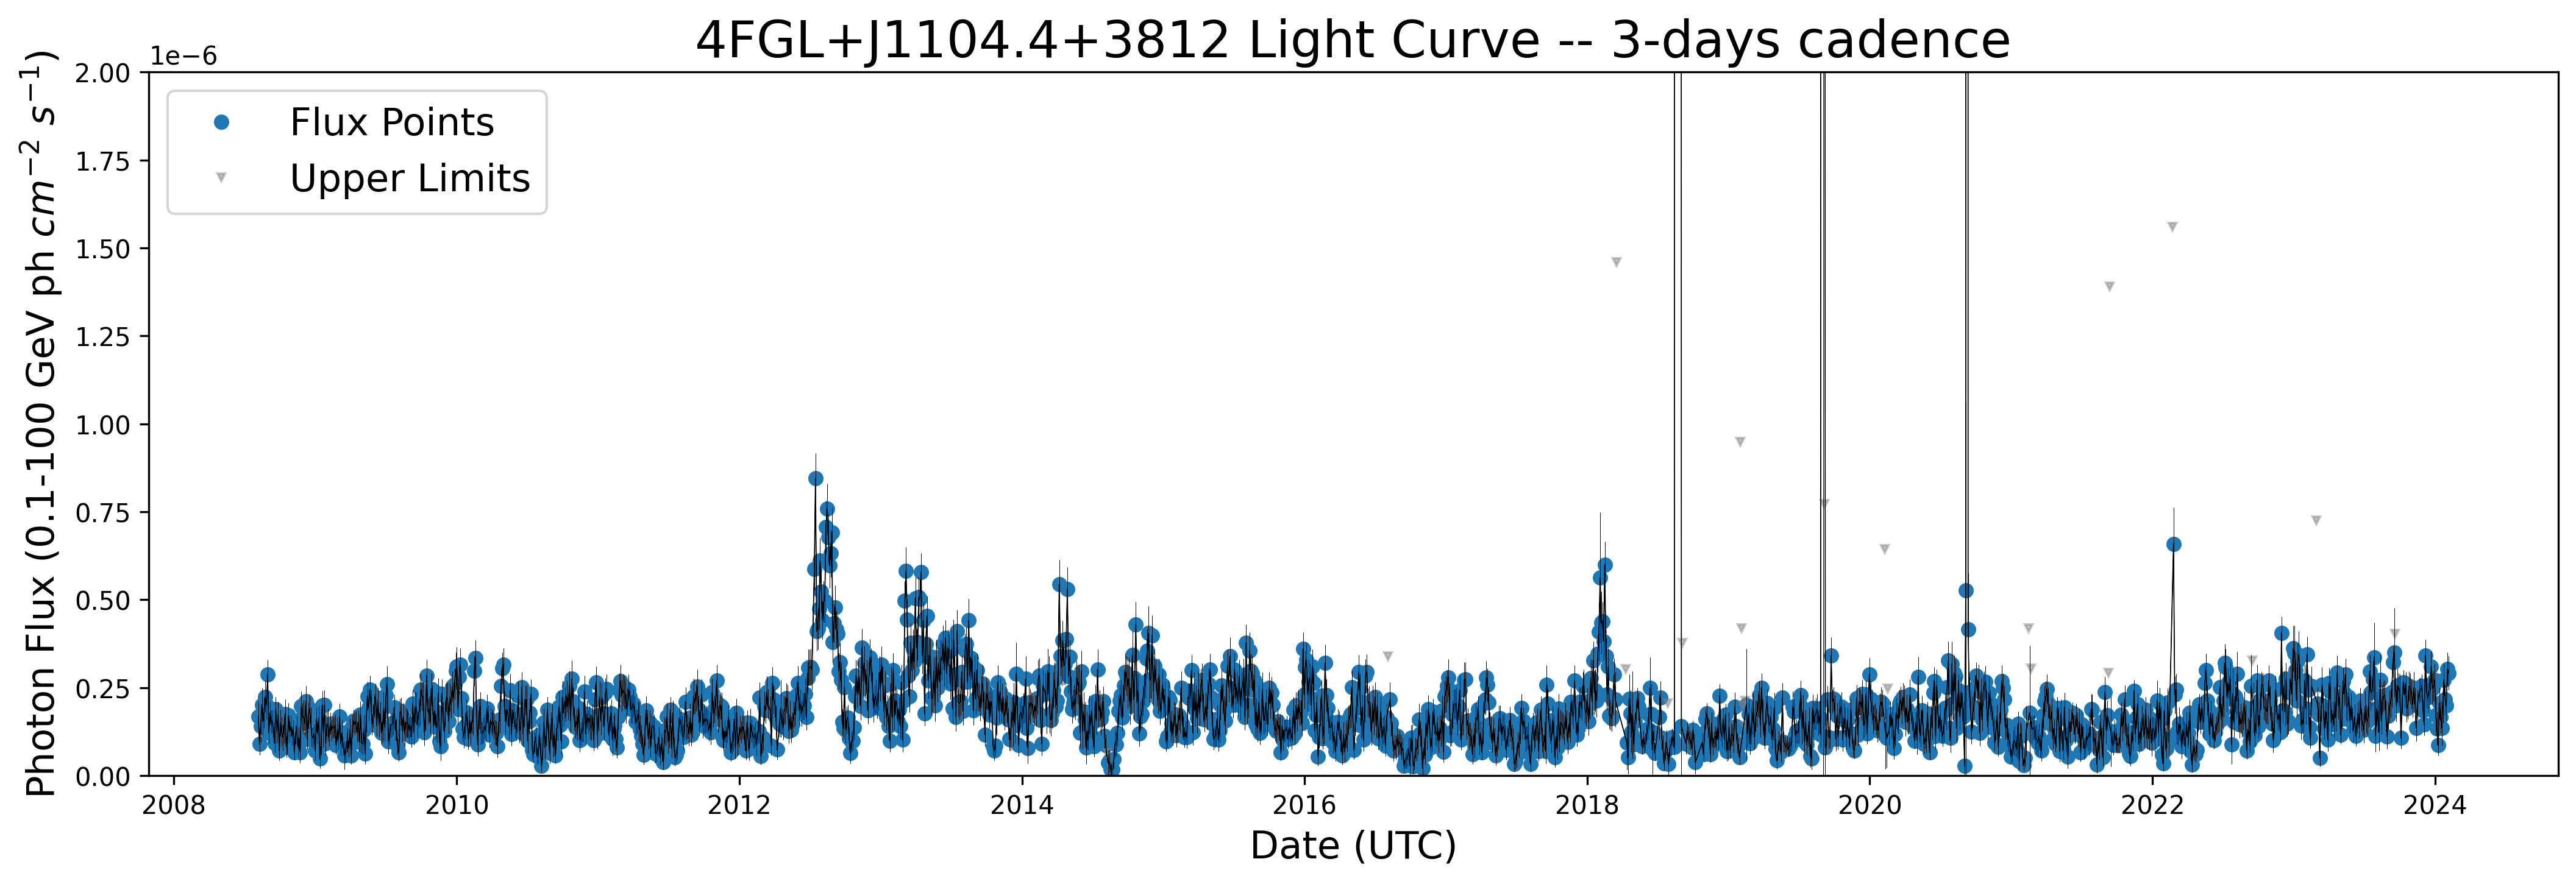

In [20]:
plots.lightcurve_complete(binning, 2e-6)

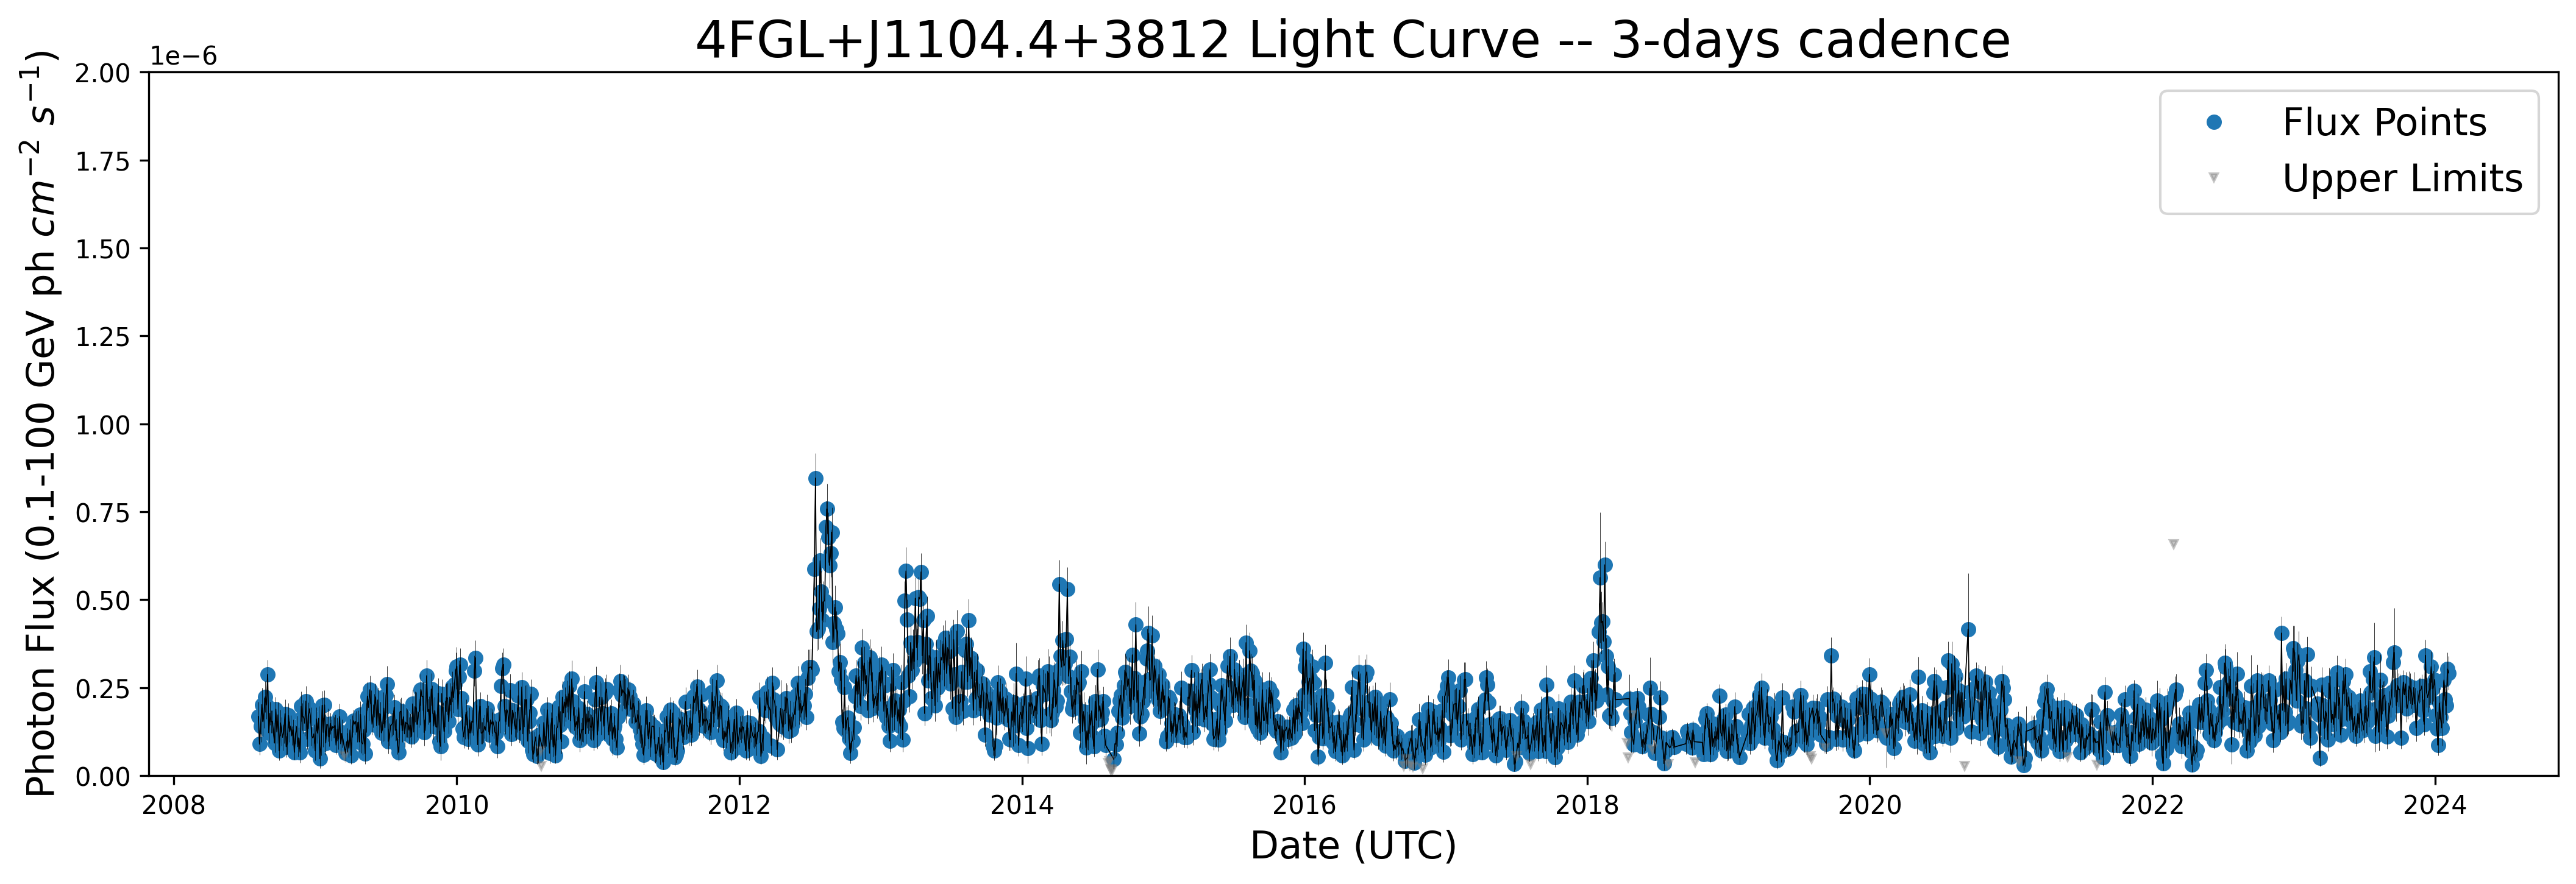

In [21]:
plots.lightcurve_filtered(binning, 2e-6)

In [22]:
## plot spectrum

In [23]:
## plot exposure and relevant info

## Entire subset of downloaded sources - 1429 sources in each folder:

Cadences:
- 3-days
- Weekly
- Monthly

Each with binning:
- fixed
- free

Let's generate a dictionary to help with each folder, you should have 1429 sources x 6 downloaded folders :)

Here we are also already generating a dictionary with only the sources that pass the Upper Limit 50% cut (with respect to flux measurements) in each folder.

### Filter 1) Upper Limits Cut

- Remove the sources (in every timescale) with n° Upper Limits > n° flux measurements

In [24]:
## generate list sources
lightcurve_files = {}
UL_filtered_files = {}

## iterate over binning and index options
for binning in ['3-days', 'weekly', 'monthly']:
    for index in ['fixed', 'free']:
        key = f'lc_{binning.replace("-", "")}_{index}_files'
        lightcurve_files[key] = generate_list_sources(binning, index)

        filtered_file_list = []
        for file_name in lightcurve_files[key]:
            source_data = Read_json_file(file_name, binning, index)
            # source_df = source_data.dataframe
            source_dict = source_data.dictionary

            len_flux_upper_limits = len(source_dict['flux_upper_limits'])
            len_flux_measur = len(source_dict['flux'])

            if len_flux_upper_limits <= len_flux_measur:
                filtered_file_list.append(file_name)

            UL_filtered_files[key] = filtered_file_list


            
## now we have lists for each binning option with each index option
lc_3days_fixed_files = lightcurve_files['lc_3days_fixed_files']
lc_weekly_fixed_files = lightcurve_files['lc_weekly_fixed_files']
lc_monthly_fixed_files = lightcurve_files['lc_monthly_fixed_files']
lc_3days_free_files = lightcurve_files['lc_3days_free_files']
lc_weekly_free_files = lightcurve_files['lc_weekly_free_files']
lc_monthly_free_files = lightcurve_files['lc_monthly_free_files']

## and also the list with sources that pass the Upper Limit cut :)
filtered_lc_3days_fixed_files = UL_filtered_files['lc_3days_fixed_files']
filtered_lc_weekly_fixed_files = UL_filtered_files['lc_weekly_fixed_files']
filtered_lc_monthly_fixed_files = UL_filtered_files['lc_monthly_fixed_files']
filtered_lc_3days_free_files = UL_filtered_files['lc_3days_free_files']
filtered_lc_weekly_free_files = UL_filtered_files['lc_weekly_free_files']
filtered_lc_monthly_free_files = UL_filtered_files['lc_monthly_free_files']

In [25]:
lightcurve_files.keys()

dict_keys(['lc_3days_fixed_files', 'lc_3days_free_files', 'lc_weekly_fixed_files', 'lc_weekly_free_files', 'lc_monthly_fixed_files', 'lc_monthly_free_files'])

In [26]:
UL_filtered_files.keys()

dict_keys(['lc_3days_fixed_files', 'lc_3days_free_files', 'lc_weekly_fixed_files', 'lc_weekly_free_files', 'lc_monthly_fixed_files', 'lc_monthly_free_files'])

In [27]:
print('------- 3-days -------')
print(f'We have now {len(filtered_lc_3days_fixed_files)} files instead of {len(lc_3days_fixed_files)}')

print('\n------- weekly -------')
print(f'We have now {len(filtered_lc_weekly_fixed_files)} files instead of {len(lc_weekly_fixed_files)}')

print('\n------- monthly -------')
print(f'We have now {len(filtered_lc_monthly_fixed_files)} files instead of {len(lc_monthly_fixed_files)}')

------- 3-days -------
We have now 173 files instead of 1429

------- weekly -------
We have now 339 files instead of 1429

------- monthly -------
We have now 803 files instead of 1429


---- From now on, we are only going to use the fixed index case, for 3-days, weekly and monthly binnings.


### Filter 2) Flux Points Cut

Remove, from the .json file of each source, the flux points in which

- flux_error = 0
- fit_convergence !=0
- exposure (flux / flux_error²) < 1e7 cm²s

### Filter 3) Flux Points -> Upper Limit Points

Make the point an Upper Limit if
- TS < 10

(minimal Test Statistic: significance of the detection)



---> to be implemented: delta_loglikelihood, change free -> fixed index

3-days:

In [28]:
len(filtered_lc_3days_fixed_files)

173

In [29]:
source_names_3days_fixed = []
sigma_nxs_3days_fixed = []
err_sigma_nxs_3days_fixed = []
fvar_3days_fixed = []
unc_fvar_3days_fixed = []

for file_name in filtered_lc_3days_fixed_files:
    
    source_data = Read_json_file(file_name, '3-days', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df = filter_source_flux(source_df)
    
    variability = Estimate_variability(filtered_df)
    sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
    source_names_3days_fixed.append(file_name[5:-5])
    sigma_nxs_3days_fixed.append(sigma_nxs)
    err_sigma_nxs_3days_fixed.append(err_sigma_nxs)
    fvar_3days_fixed.append(fvar)
    unc_fvar_3days_fixed.append(err_fvar)
    
df_variability_3days_fixed = pd.DataFrame(list(zip(source_names_3days_fixed,
                                                     sigma_nxs_3days_fixed, err_sigma_nxs_3days_fixed,
                                                     fvar_3days_fixed, unc_fvar_3days_fixed)),
                                            columns =['Source_Name', 'sigma²_NXS(3-days)', 'err_sigma²_NXS(3-days)',
                                                      'Fvar(3-days)', 'err_Fvar(3-days)'])

In [30]:
df_variability_3days_fixed

,Source_Name,sigma²_NXS(3-days),err_sigma²_NXS(3-days),Fvar(3-days),err_Fvar(3-days)
0,J0043.8+3425,-0.019471,0.015863,0.000000,0.100000
1,J0050.7-0929,-0.049708,0.011065,0.000000,0.100000
2,J0102.8+5824,0.195591,0.015823,0.442256,0.017888
3,J0108.6+0134,0.961225,0.009988,0.980421,0.005094
4,J0112.1+2245,0.180104,0.010745,0.424387,0.012660
...,...,...,...,...,...
168,J2323.5-0317,0.382500,0.023621,0.618466,0.019096
169,J2329.3-4955,0.650813,0.013029,0.806730,0.008075
170,J2345.2-1555,0.538446,0.018728,0.733789,0.012761
171,J2347.0+5141,-0.107116,0.017116,0.000000,0.100000


Weekly:

In [31]:
len(filtered_lc_weekly_fixed_files)

339

In [32]:
source_names_weekly_fixed = []
sigma_nxs_weekly_fixed = []
err_sigma_nxs_weekly_fixed = []
fvar_weekly_fixed = []
unc_fvar_weekly_fixed = []

for file_name in filtered_lc_weekly_fixed_files:
    
    source_data = Read_json_file(file_name, 'weekly', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df = filter_source_flux(source_df)
    
    variability = Estimate_variability(filtered_df)
    sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
    source_names_weekly_fixed.append(file_name[5:-5])
    sigma_nxs_weekly_fixed.append(sigma_nxs)
    err_sigma_nxs_weekly_fixed.append(err_sigma_nxs)
    fvar_weekly_fixed.append(fvar)
    unc_fvar_weekly_fixed.append(err_fvar)
    
df_variability_weekly_fixed = pd.DataFrame(list(zip(source_names_weekly_fixed,
                                                     sigma_nxs_weekly_fixed, err_sigma_nxs_weekly_fixed,
                                                     fvar_weekly_fixed, unc_fvar_weekly_fixed)),
                                            columns =['Source_Name', 'sigma²_NXS(weekly)', 'err_sigma²_NXS(weekly)',
                                                      'Fvar(weekly)', 'err_Fvar(weekly)'])

/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:96: RuntimeWarning: invalid value encountered in sqrt
  self.unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * self.normalized_excess_variance) )
/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:96: RuntimeWarning: invalid value encountered in sqrt
  self.unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * self.normalized_excess_variance) )
/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:96: RuntimeWarning: invalid value encountered in sqrt
  self.unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * self.normalized_excess_variance) )
/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:96: RuntimeWarning: invalid value encountered in sqrt
  self.unc_n

In [33]:
df_variability_weekly_fixed

,Source_Name,sigma²_NXS(weekly),err_sigma²_NXS(weekly),Fvar(weekly),err_Fvar(weekly)
0,J0001.5+2113,0.487329,0.024063,0.698090,0.017235
1,J0009.3+5030,-0.062017,0.012422,0.000000,0.100000
2,J0022.5+0608,0.010893,0.017715,0.104369,0.084866
3,J0030.3-4224,0.398482,0.030107,0.631254,0.023847
4,J0030.6-0212,0.284148,0.024906,0.533055,0.023361
...,...,...,...,...,...
334,J2329.3-4955,0.853292,0.014831,0.923738,0.008028
335,J2331.0-2147,0.247912,0.027979,0.497908,0.028097
336,J2345.2-1555,0.768994,0.022072,0.876923,0.012585
337,J2347.0+5141,-0.051192,0.016149,0.000000,0.100000


Monthly:

In [34]:
len(filtered_lc_monthly_fixed_files)

803

In [35]:
source_names_monthly_fixed = []
sigma_nxs_monthly_fixed = []
err_sigma_nxs_monthly_fixed = []
fvar_monthly_fixed = []
unc_fvar_monthly_fixed = []

for file_name in filtered_lc_monthly_fixed_files:
    
    source_data = Read_json_file(file_name, 'monthly', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df = filter_source_flux(source_df)
    
    variability = Estimate_variability(filtered_df)
    sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
    source_names_monthly_fixed.append(file_name[5:-5])
    sigma_nxs_monthly_fixed.append(sigma_nxs)
    err_sigma_nxs_monthly_fixed.append(err_sigma_nxs)
    fvar_monthly_fixed.append(fvar)
    unc_fvar_monthly_fixed.append(err_fvar)
    
df_variability_monthly_fixed = pd.DataFrame(list(zip(source_names_monthly_fixed,
                                                     sigma_nxs_monthly_fixed, err_sigma_nxs_monthly_fixed,
                                                     fvar_monthly_fixed, unc_fvar_monthly_fixed)),
                                            columns =['Source_Name', 'sigma²_NXS(monthly)', 'err_sigma²_NXS(monthly)',
                                                      'Fvar(monthly)', 'err_Fvar(monthly)'])

/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:96: RuntimeWarning: invalid value encountered in sqrt
  self.unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * self.normalized_excess_variance) )
/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:96: RuntimeWarning: invalid value encountered in sqrt
  self.unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * self.normalized_excess_variance) )
/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:96: RuntimeWarning: invalid value encountered in sqrt
  self.unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * self.normalized_excess_variance) )
/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:96: RuntimeWarning: invalid value encountered in sqrt
  self.unc_n

In [36]:
df_variability_monthly_fixed

,Source_Name,sigma²_NXS(monthly),err_sigma²_NXS(monthly),Fvar(monthly),err_Fvar(monthly)
0,J0001.2-0747,-0.090948,0.002365,0.000000,0.100000
1,J0001.5+2113,0.821839,0.031841,0.906554,0.017561
2,J0004.4-4737,0.090036,0.040113,0.300061,0.066842
3,J0005.9+3824,-0.005546,0.026273,0.000000,0.100000
4,J0007.7+4008,-0.072854,0.006462,0.000000,0.100000
...,...,...,...,...,...
798,J2347.0+5141,0.059337,0.017291,0.243591,0.035492
799,J2348.0-1630,0.659113,0.022290,0.811858,0.013728
800,J2355.7-3351,-0.021041,0.046153,0.000000,0.100000
801,J2358.3+3830,-0.109591,NaN,0.000000,0.100000


Let's add now the estimated values into the original 4lac_dr3 dataframe:

In [37]:
merged_df_3days = df_agn_pop_4lac_dr3.merge(df_variability_3days_fixed, on='Source_Name', how='left')

In [38]:
merged_df_weekly = merged_df_3days.merge(df_variability_weekly_fixed, on='Source_Name', how='left')

In [39]:
merged_df = merged_df_weekly.merge(df_variability_monthly_fixed, on='Source_Name', how='left')

In [40]:
merged_df

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,...,Fvar(3-days),err_Fvar(3-days),sigma²_NXS(weekly),err_sigma²_NXS(weekly),Fvar(weekly),err_Fvar(weekly),sigma²_NXS(monthly),err_sigma²_NXS(monthly),Fvar(monthly),err_Fvar(monthly)
0,J0001.2+4741,0.312600,47.685902,-inf,PowerLaw,2420.575195,2.156031e-14,2.271696,2.196550e-14,2.254081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J0001.2-0747,0.315100,-7.797100,-inf,PowerLaw,1721.603882,2.656894e-13,2.116692,2.842831e-13,2.078927,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.090948,0.002365,0.000000,0.100000
2,J0001.4-0010,0.371700,-0.169900,0.461516,PowerLaw,4307.082520,6.067356e-15,1.939160,6.488817e-15,1.661223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J0001.5+2113,0.381500,21.218300,1.106000,LogParabola,329.773743,4.683598e-11,2.654060,5.371562e-11,2.514159,...,NaN,NaN,0.487329,0.024063,0.69809,0.017235,0.821839,0.031841,0.906554,0.017561
4,J0001.6-4156,0.416500,-41.942501,-inf,PowerLaw,4047.030029,1.881541e-14,1.775175,2.131597e-14,1.693865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,J2359.3+0215,359.832886,2.260300,-inf,LogParabola,5170.603516,5.111725e-15,1.757034,9.790216e-15,1.644894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3810,J2359.3-2049,359.835693,-20.818899,0.096000,PowerLaw,2594.249756,5.196033e-14,1.984188,5.197384e-14,1.982751,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3811,J2359.7-5041,359.936493,-50.685299,-inf,LogParabola,842.054199,1.846089e-13,2.684101,3.137423e-13,2.596392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3812,J2359.9-3736,359.981598,-37.616001,-inf,PowerLaw,1730.675415,6.743669e-14,2.120209,8.021262e-14,2.007299,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
## rename columns for saving file
table_agn_pop_4lac_dr3_variability = merged_df.copy()

table_agn_pop_4lac_dr3_variability.rename(columns={
    'sigma²_NXS(3-days)': 'Norm_Excess_Var(3-days)',
    'err_sigma²_NXS(3-days)': 'err_Norm_Excess_Var(3-days)',
    'sigma²_NXS(weekly)': 'Norm_Excess_Var(weekly)',
    'err_sigma²_NXS(weekly)': 'err_Norm_Excess_Var(weekly)',
    'sigma²_NXS(monthly)': 'Norm_Excess_Var(monthly)',
    'err_sigma²_NXS(monthly)': 'err_Norm_Excess_Var(monthly)'
}, inplace=True)

In [42]:
table_astropy = Table.from_pandas(table_agn_pop_4lac_dr3_variability)

table_astropy.write('./resulting_catalogs/variability_complete_agn_pop_4lac_dr3.ecsv', format='ascii.ecsv', overwrite=True)
table_astropy.write('./resulting_catalogs/variability_complete_agn_pop_4lac_dr3.fits', format='fits', overwrite=True)

In [43]:
columns_to_keep = ['Source_Name', 'Norm_Excess_Var(monthly)', 'err_Norm_Excess_Var(monthly)',
                   'Norm_Excess_Var(3-days)', 'err_Norm_Excess_Var(3-days)']

table_df = table_agn_pop_4lac_dr3_variability[columns_to_keep]

In [44]:
table_df

,Source_Name,Norm_Excess_Var(monthly),err_Norm_Excess_Var(monthly),Norm_Excess_Var(3-days),err_Norm_Excess_Var(3-days)
0,J0001.2+4741,NaN,NaN,NaN,NaN
1,J0001.2-0747,-0.090948,0.002365,NaN,NaN
2,J0001.4-0010,NaN,NaN,NaN,NaN
3,J0001.5+2113,0.821839,0.031841,NaN,NaN
4,J0001.6-4156,NaN,NaN,NaN,NaN
...,...,...,...,...,...
3809,J2359.3+0215,NaN,NaN,NaN,NaN
3810,J2359.3-2049,NaN,NaN,NaN,NaN
3811,J2359.7-5041,NaN,NaN,NaN,NaN
3812,J2359.9-3736,NaN,NaN,NaN,NaN


In [45]:
final_table = Table.from_pandas(table_df)

final_table.write('./resulting_catalogs/reliable_variability_agn_pop_4lac_dr3.ecsv', format='ascii.ecsv', overwrite=True)
final_table.write('./resulting_catalogs/reliable_variability_agn_pop_4lac_dr3.fits', format='fits', overwrite=True)

In [46]:
## plots after filter

## plot_all_info
## cleaned_dataframe and cleaned_dictionary

In [47]:
## variability reliable plots

In [48]:
# reliable mask - for 3-days

table_3days = table_df[table_df['Norm_Excess_Var(3-days)'].notna()]

In [49]:
table_3days

,Source_Name,Norm_Excess_Var(monthly),err_Norm_Excess_Var(monthly),Norm_Excess_Var(3-days),err_Norm_Excess_Var(3-days)
129,J0043.8+3425,0.224998,0.022203,-0.019471,0.015863
150,J0050.7-0929,0.174208,0.017753,-0.049708,0.011065
188,J0102.8+5824,0.505351,0.021014,0.195591,0.015823
200,J0108.6+0134,1.326297,0.011324,0.961225,0.009988
213,J0112.1+2245,0.337992,0.012077,0.180104,0.010745
...,...,...,...,...,...
3702,J2323.5-0317,0.767361,0.028683,0.382500,0.023621
3723,J2329.3-4955,1.353821,0.017716,0.650813,0.013029
3764,J2345.2-1555,1.110689,0.026874,0.538446,0.018728
3768,J2347.0+5141,0.059337,0.017291,-0.107116,0.017116


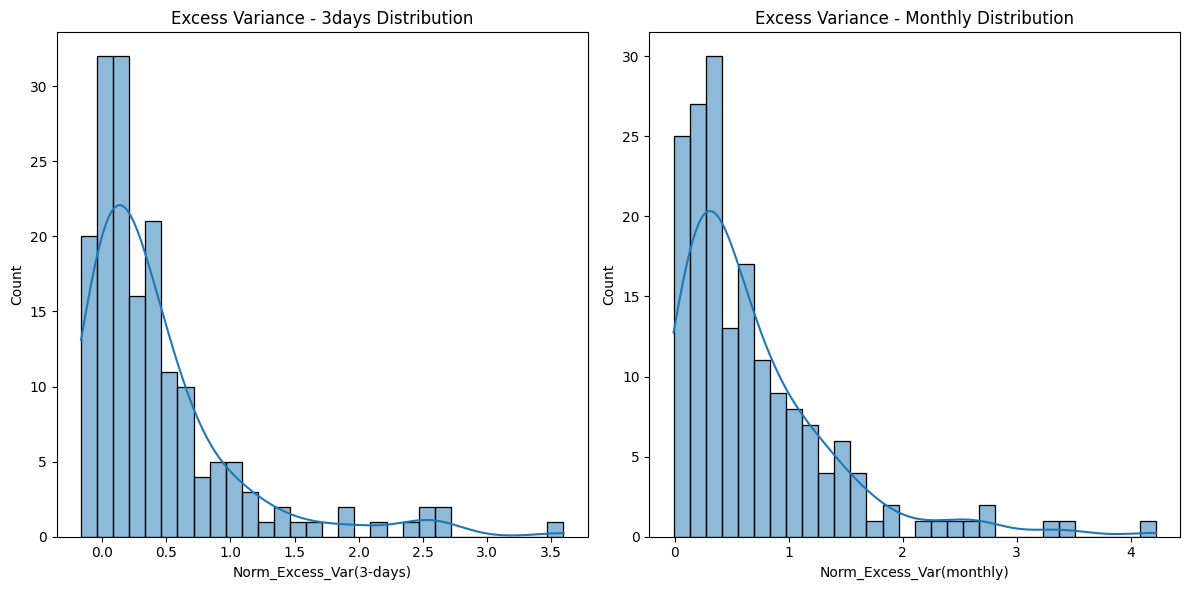

In [50]:
## show the distributions (histograms) of V_NXS(3-day) and V_NXS(month)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.histplot(table_3days['Norm_Excess_Var(3-days)'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Excess Variance - 3days Distribution')

sns.histplot(table_3days['Norm_Excess_Var(monthly)'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Excess Variance - Monthly Distribution')

plt.tight_layout()
plt.show()

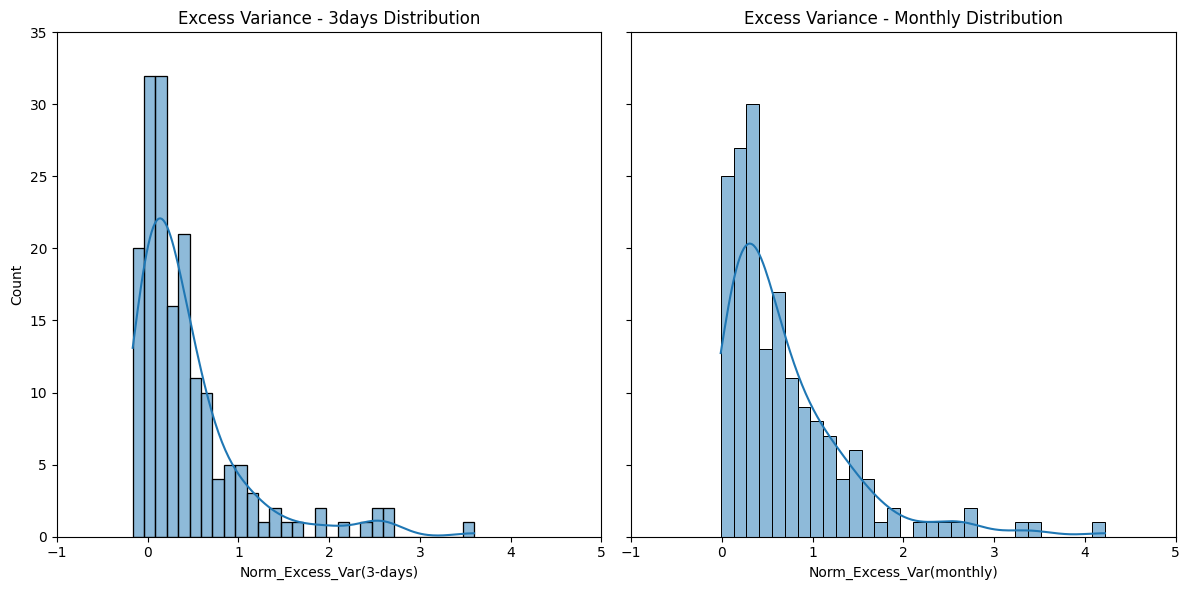

In [51]:
## x and y with same values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

sns.histplot(table_3days['Norm_Excess_Var(3-days)'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Excess Variance - 3days Distribution')
axes[0].set_xlim(-1, 5)
axes[0].set_ylim(0, 35)

sns.histplot(table_3days['Norm_Excess_Var(monthly)'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Excess Variance - Monthly Distribution')

plt.tight_layout()
plt.show()

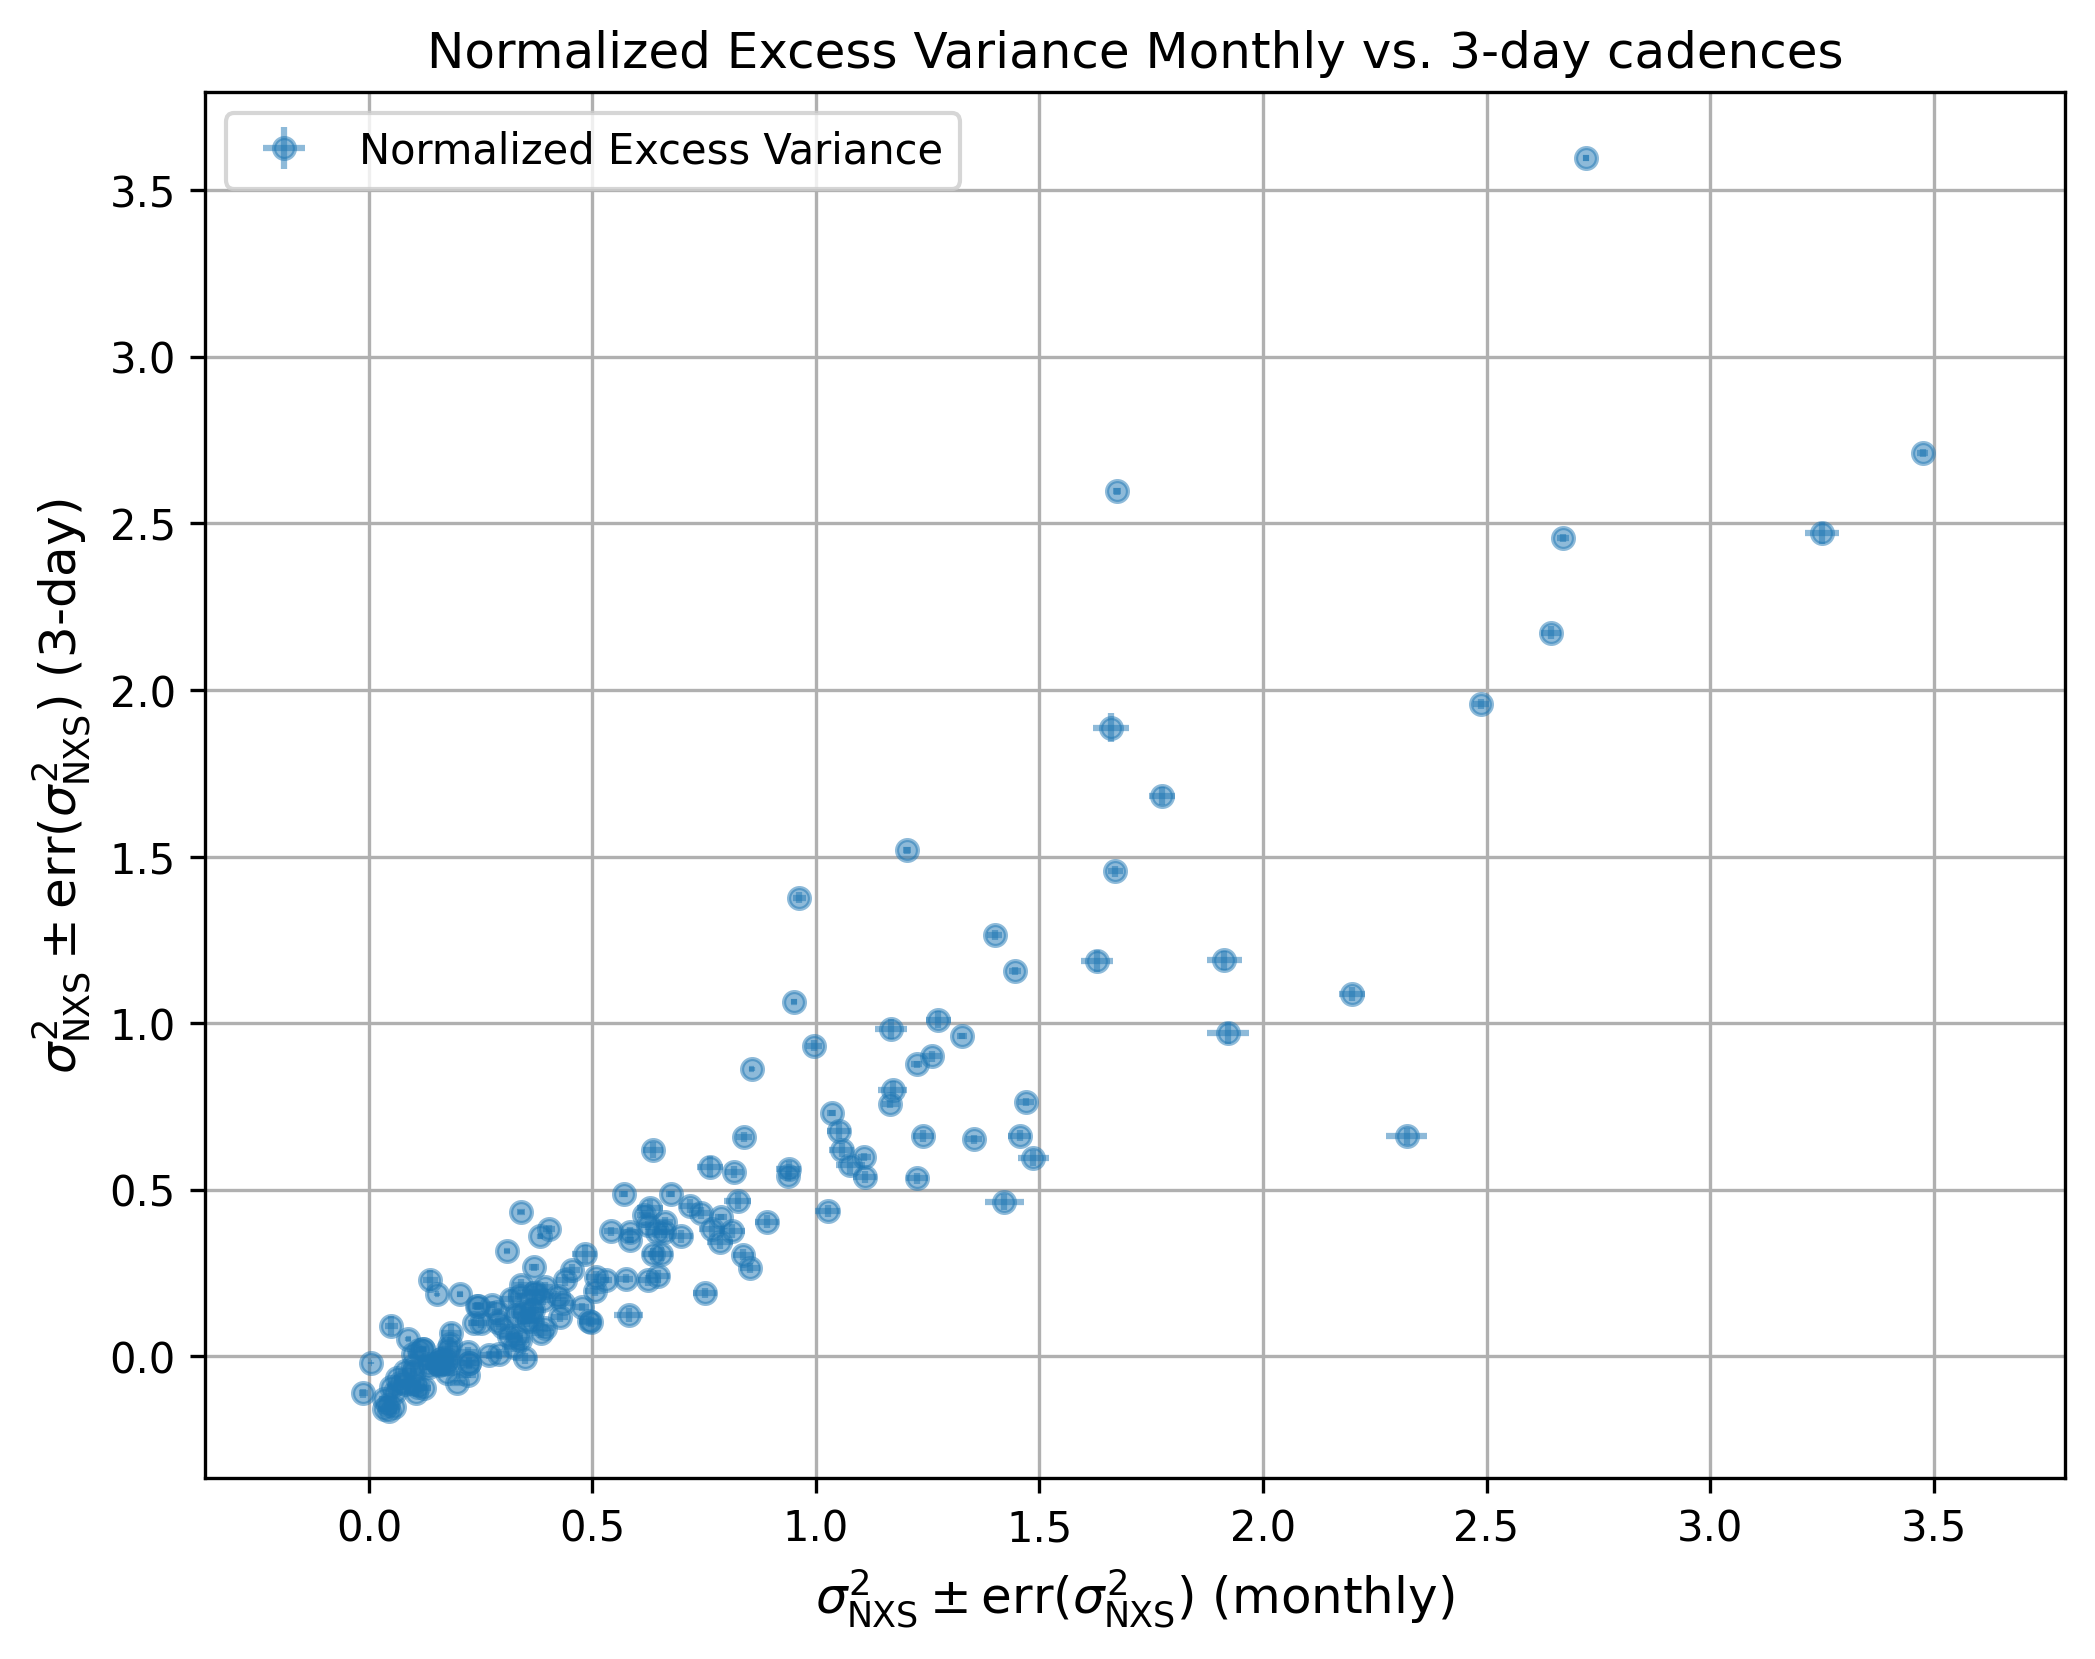

In [52]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

plt.errorbar(table_3days['Norm_Excess_Var(monthly)'], table_3days['Norm_Excess_Var(3-days)'],
             xerr=table_3days['err_Norm_Excess_Var(monthly)'], yerr=table_3days['err_Norm_Excess_Var(3-days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title('Normalized Excess Variance Monthly vs. 3-day cadences', fontsize=12)
plt.legend()

# plt.xscale('log')
# plt.yscale('log')

plt.xlim(plt.ylim())
# plt.ylim(plt.xlim())

plt.grid(True)
plt.show()

In [53]:
x = table_3days['Norm_Excess_Var(monthly)']
y = table_3days['Norm_Excess_Var(3-days)']
x_err = table_3days['err_Norm_Excess_Var(monthly)']
y_err = table_3days['err_Norm_Excess_Var(3-days)']

In [54]:
len(x)

173

In [55]:
from scipy.odr import ODR, Model, RealData

def linear_func(B, x):
    return B[0] * x + B[1]

linear_model = Model(linear_func)
data = RealData(x, y, sx=x_err, sy=y_err)

odr = ODR(data, linear_model, beta0=[1., 2.])
output = odr.run()
output.pprint()

## extract the slope and its uncertainty
slope = output.beta[0]
slope_err = output.sd_beta[0]

intercept = output.beta[1]
intercept_err = output.sd_beta[1]

print(f"Slope: {slope}")
print(f"Slope uncertainty: {slope_err}")
print(f"Residual Variance: {output.res_var}")
print(f"Intercept: {intercept}")
print(f"Intercept uncertainty: {intercept_err}")

Beta: [ 1.09117695 -0.16729299]
Beta Std Error: [0.03276093 0.02457469]
Beta Covariance: [[ 5.85026404e-06 -2.68447687e-06]
 [-2.68447687e-06  3.29184224e-06]]
Residual Variance: 183.4581294727061
Inverse Condition #: 0.46658800077687923
Reason(s) for Halting:
  Sum of squares convergence
Slope: 1.0911769519728716
Slope uncertainty: 0.03276092943019956
Residual Variance: 183.4581294727061
Intercept: -0.16729299265842776
Intercept uncertainty: 0.024574686548937994


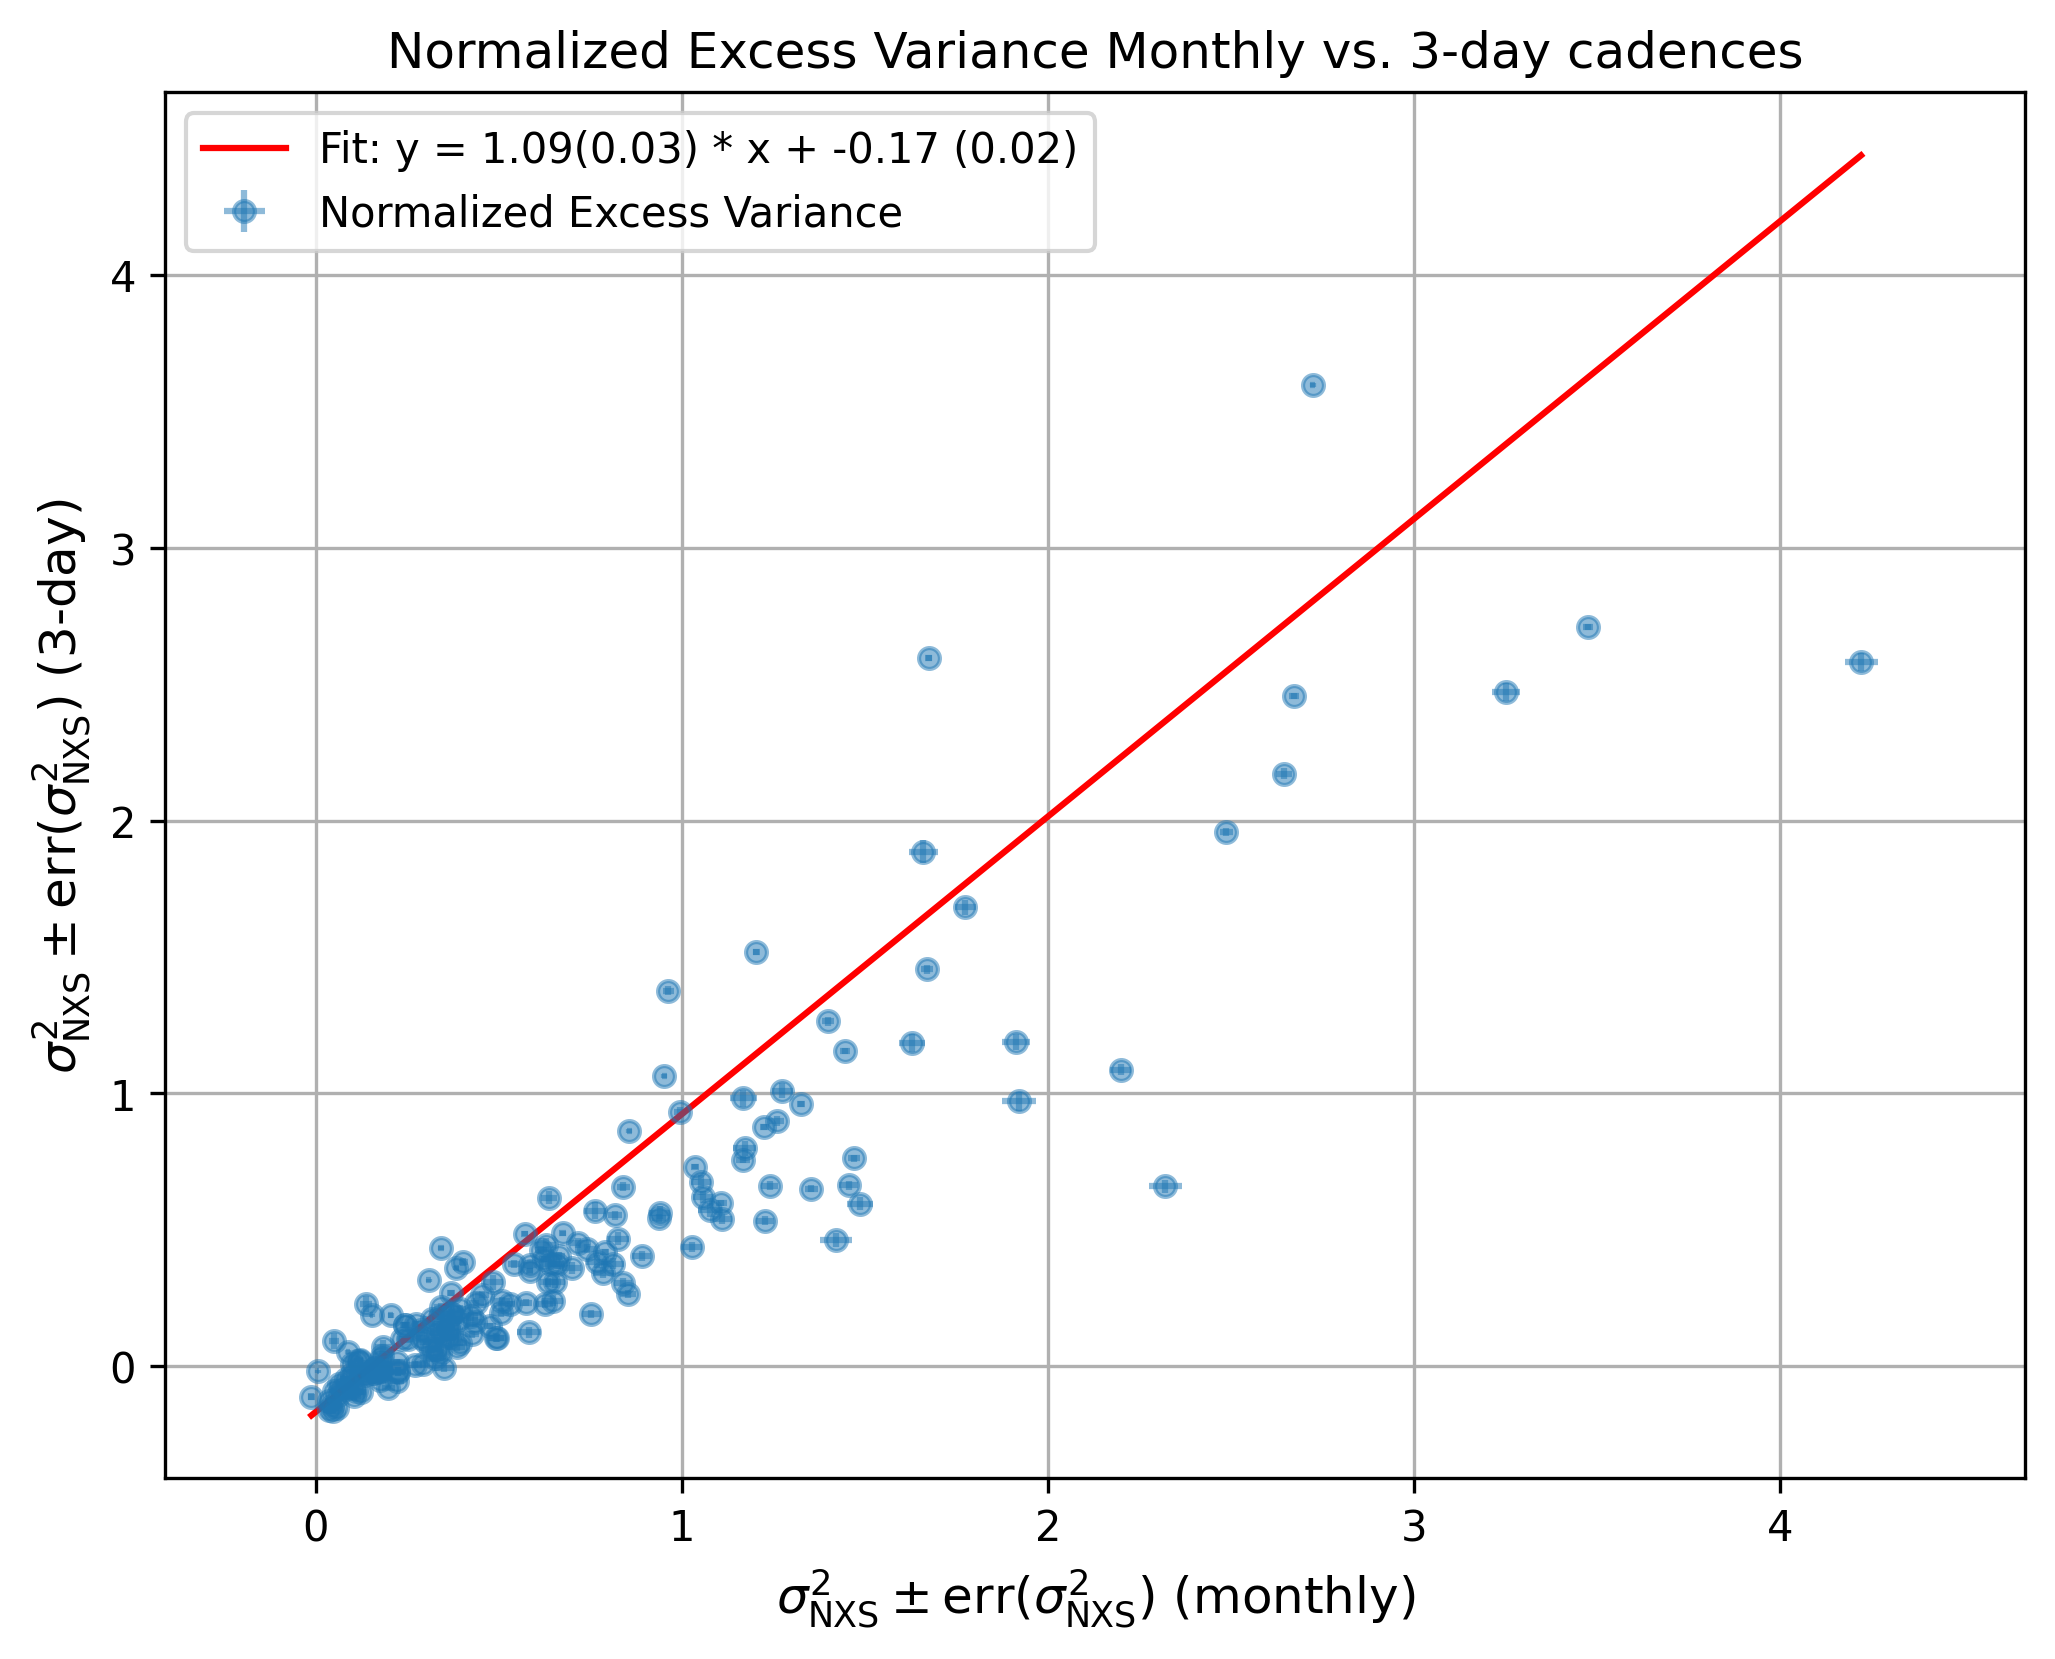

In [56]:
plt.figure(figsize=(8, 6), dpi=300)

plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', label=f'Fit: y = {slope:.2f}({slope_err:.2f}) * x + {intercept:.2f} ({intercept_err:.2f})')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title('Normalized Excess Variance Monthly vs. 3-day cadences', fontsize=12)
plt.legend()

# plt.xscale('log')
# plt.yscale('log')

plt.xlim(plt.ylim())
# plt.ylim(plt.xlim())

plt.grid(True)
plt.show()

In [57]:
# norm_excess_var_monthly_array = table_3days['Norm_Excess_Var(monthly)'].to_numpy()

# # Perform the multiplication and addition
# result_array = slope * norm_excess_var_monthly_array + intercept

# # Use .loc to avoid the SettingWithCopyWarning
# table_3days.loc[:, 'a*Norm_Excess_Var(monthly)+b'] = result_array

In [58]:
# ## add a column for the slope
# table_3days.loc[:, 'a*Norm_Excess_Var(monthly)'] = slope * table_3days['Norm_Excess_Var(monthly)'] + intercept

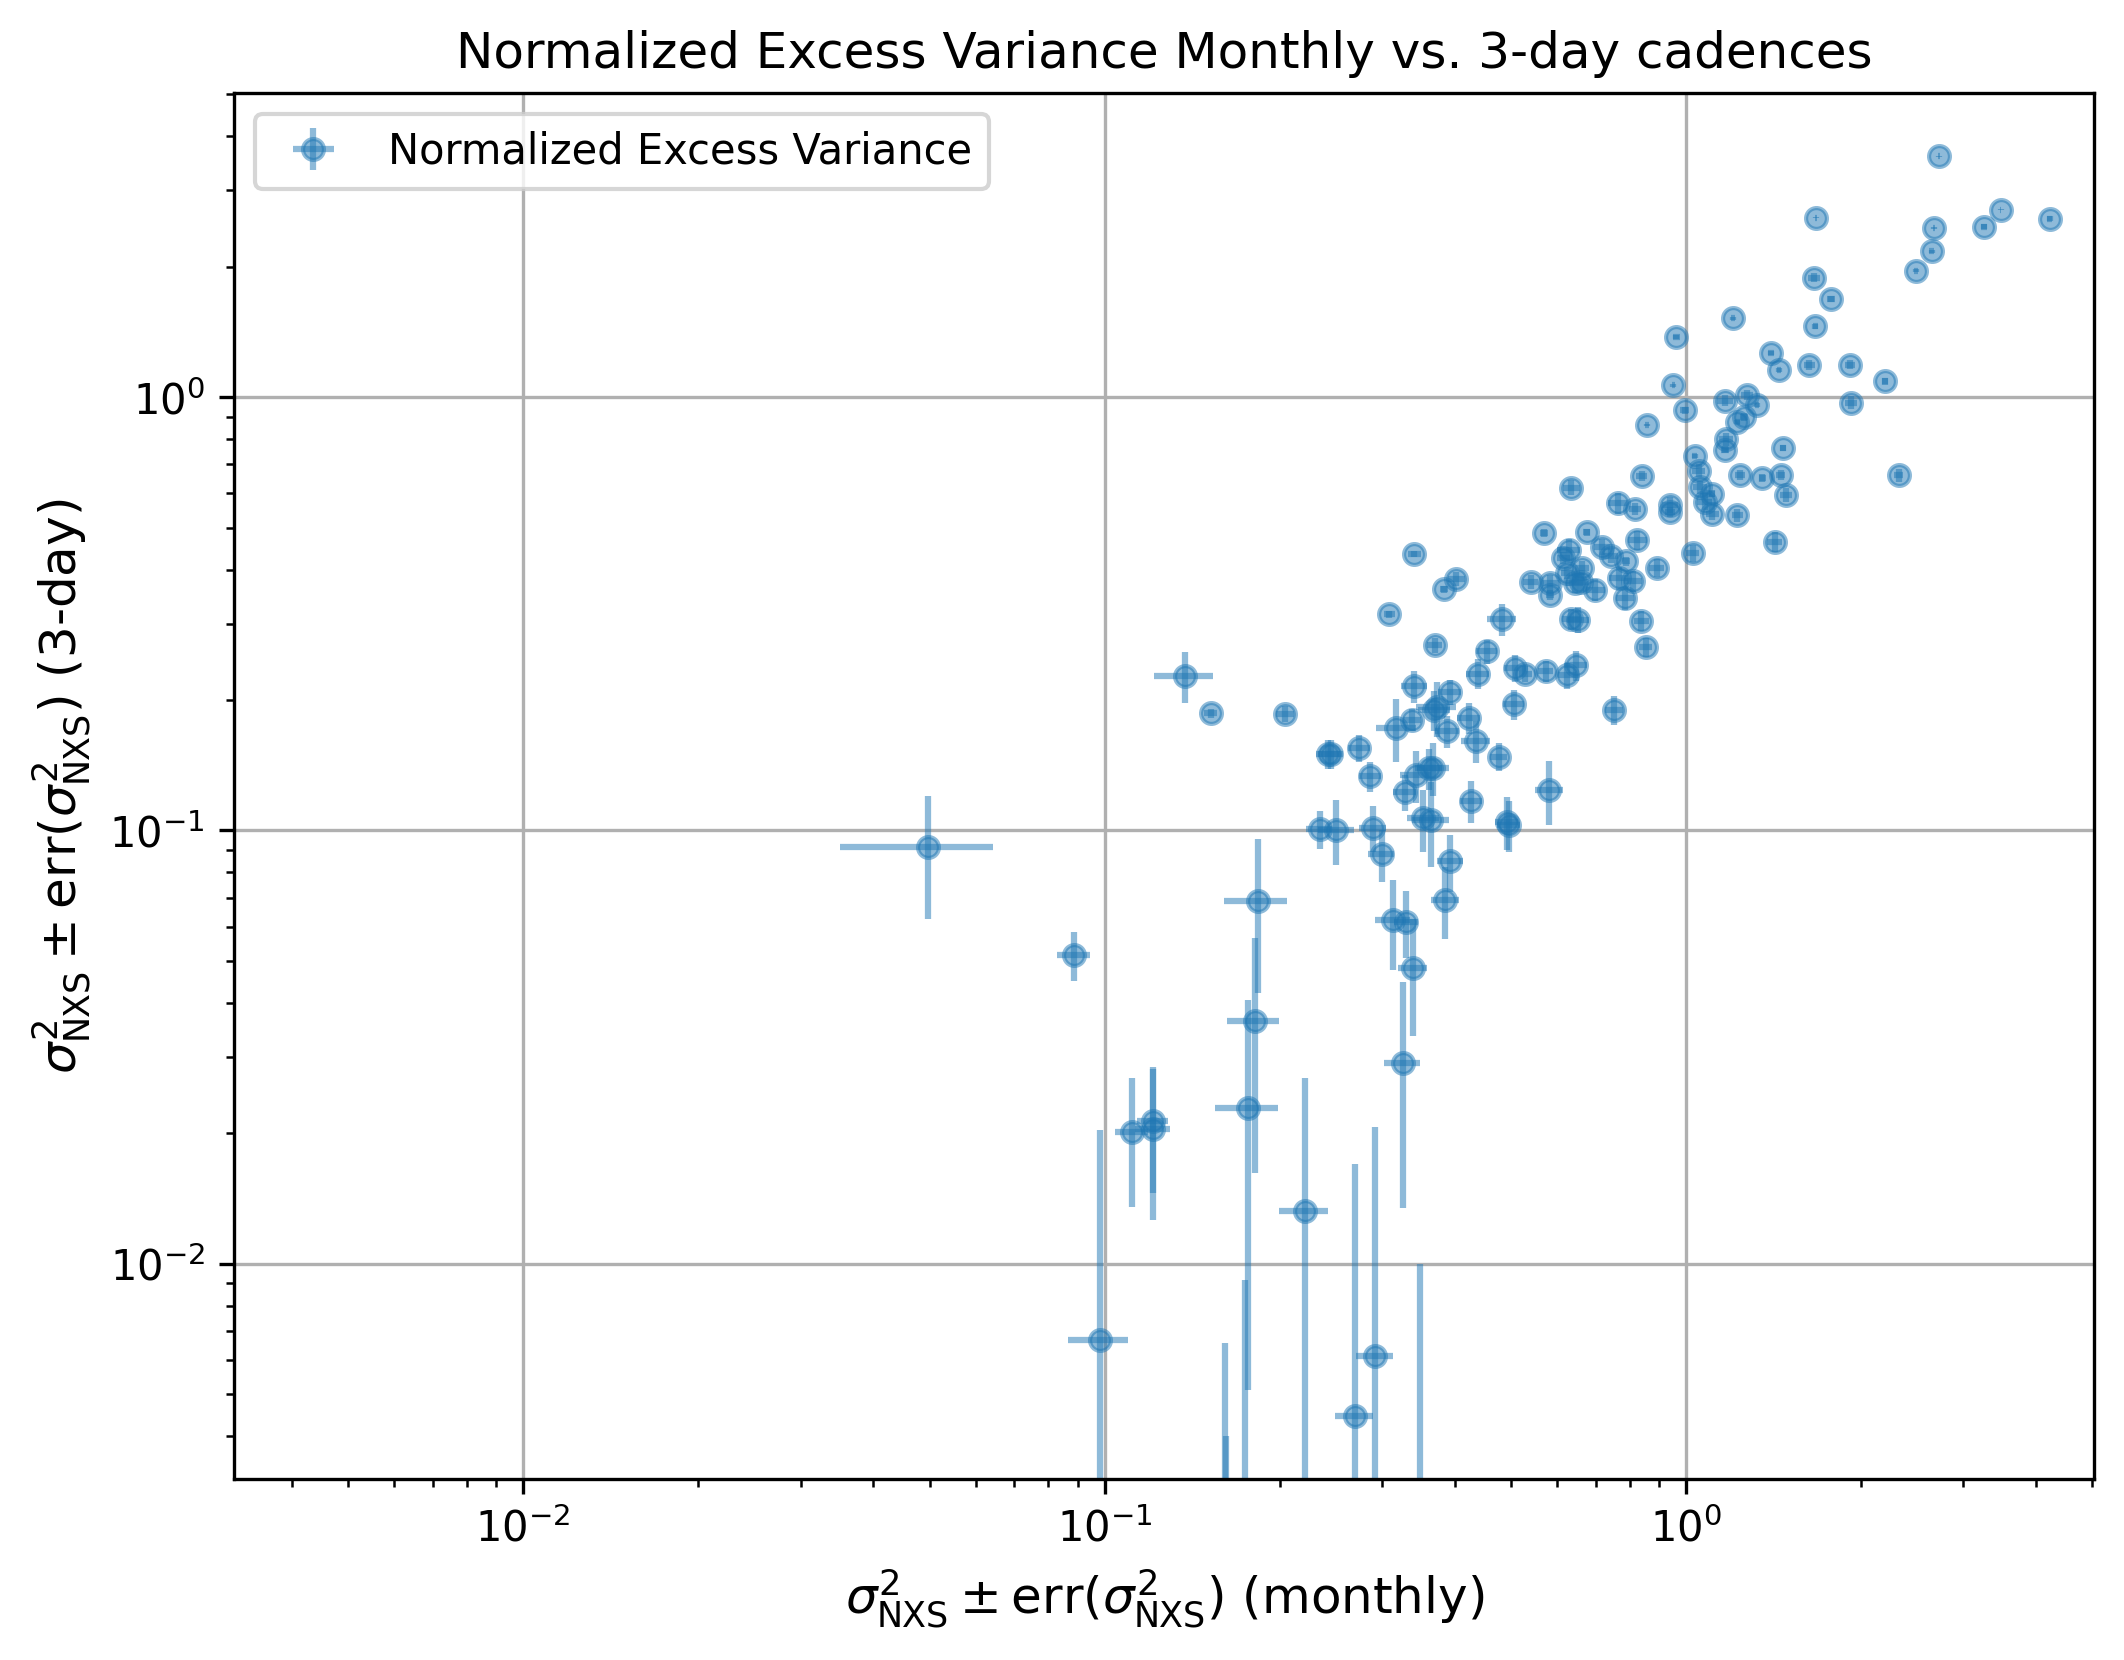

In [59]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

plt.errorbar(table_3days['Norm_Excess_Var(monthly)'], table_3days['Norm_Excess_Var(3-days)'],
             xerr=table_3days['err_Norm_Excess_Var(monthly)'], yerr=table_3days['err_Norm_Excess_Var(3-days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title('Normalized Excess Variance Monthly vs. 3-day cadences', fontsize=12)
plt.legend()

plt.xscale('log')
plt.yscale('log')


# plt.ylim(10**(-2.5),1e1)
plt.xlim(plt.ylim())
# plt.ylim(plt.xlim())

plt.grid(True)
plt.show()

In [60]:
## filter out non-positive values
valid_indices = (x > 0) & (y > 0)

x = x[valid_indices]
y = y[valid_indices]
x_err = x_err[valid_indices]
y_err = y_err[valid_indices]

In [61]:
len(x)

138

In [62]:
## Log transformation
log_x = np.log(x)
log_y = np.log(y)
log_x_err = x_err / x  # relative error in log scale
log_y_err = y_err / y  # relative error in log scale

In [63]:
def linear_func(B, x):
    return B[0] * x + B[1]

linear_model = Model(linear_func)
data = RealData(log_x, log_y, sx=log_x_err, sy=log_y_err)

odr = ODR(data, linear_model, beta0=[1., 2.])
output = odr.run()
output.pprint()

## extract the slope and its uncertainty
slope = output.beta[0]
slope_err = output.sd_beta[0]

intercept = output.beta[1]
intercept_err = output.sd_beta[1]

print(f"Slope: {slope}")
print(f"Slope uncertainty: {slope_err}")
print(f"Residual Variance: {output.res_var}")
print(f"Intercept: {intercept}")
print(f"Intercept uncertainty: {intercept_err}")

Beta: [ 1.31677389 -0.23549642]
Beta Std Error: [0.05360368 0.04506861]
Beta Covariance: [[ 1.49652150e-05 -9.43391384e-06]
 [-9.43391384e-06  1.05789356e-05]]
Residual Variance: 192.00222853351812
Inverse Condition #: 0.34543361027089003
Reason(s) for Halting:
  Sum of squares convergence
Slope: 1.316773890761005
Slope uncertainty: 0.05360368116308593
Residual Variance: 192.00222853351812
Intercept: -0.23549641789640607
Intercept uncertainty: 0.04506860562212793


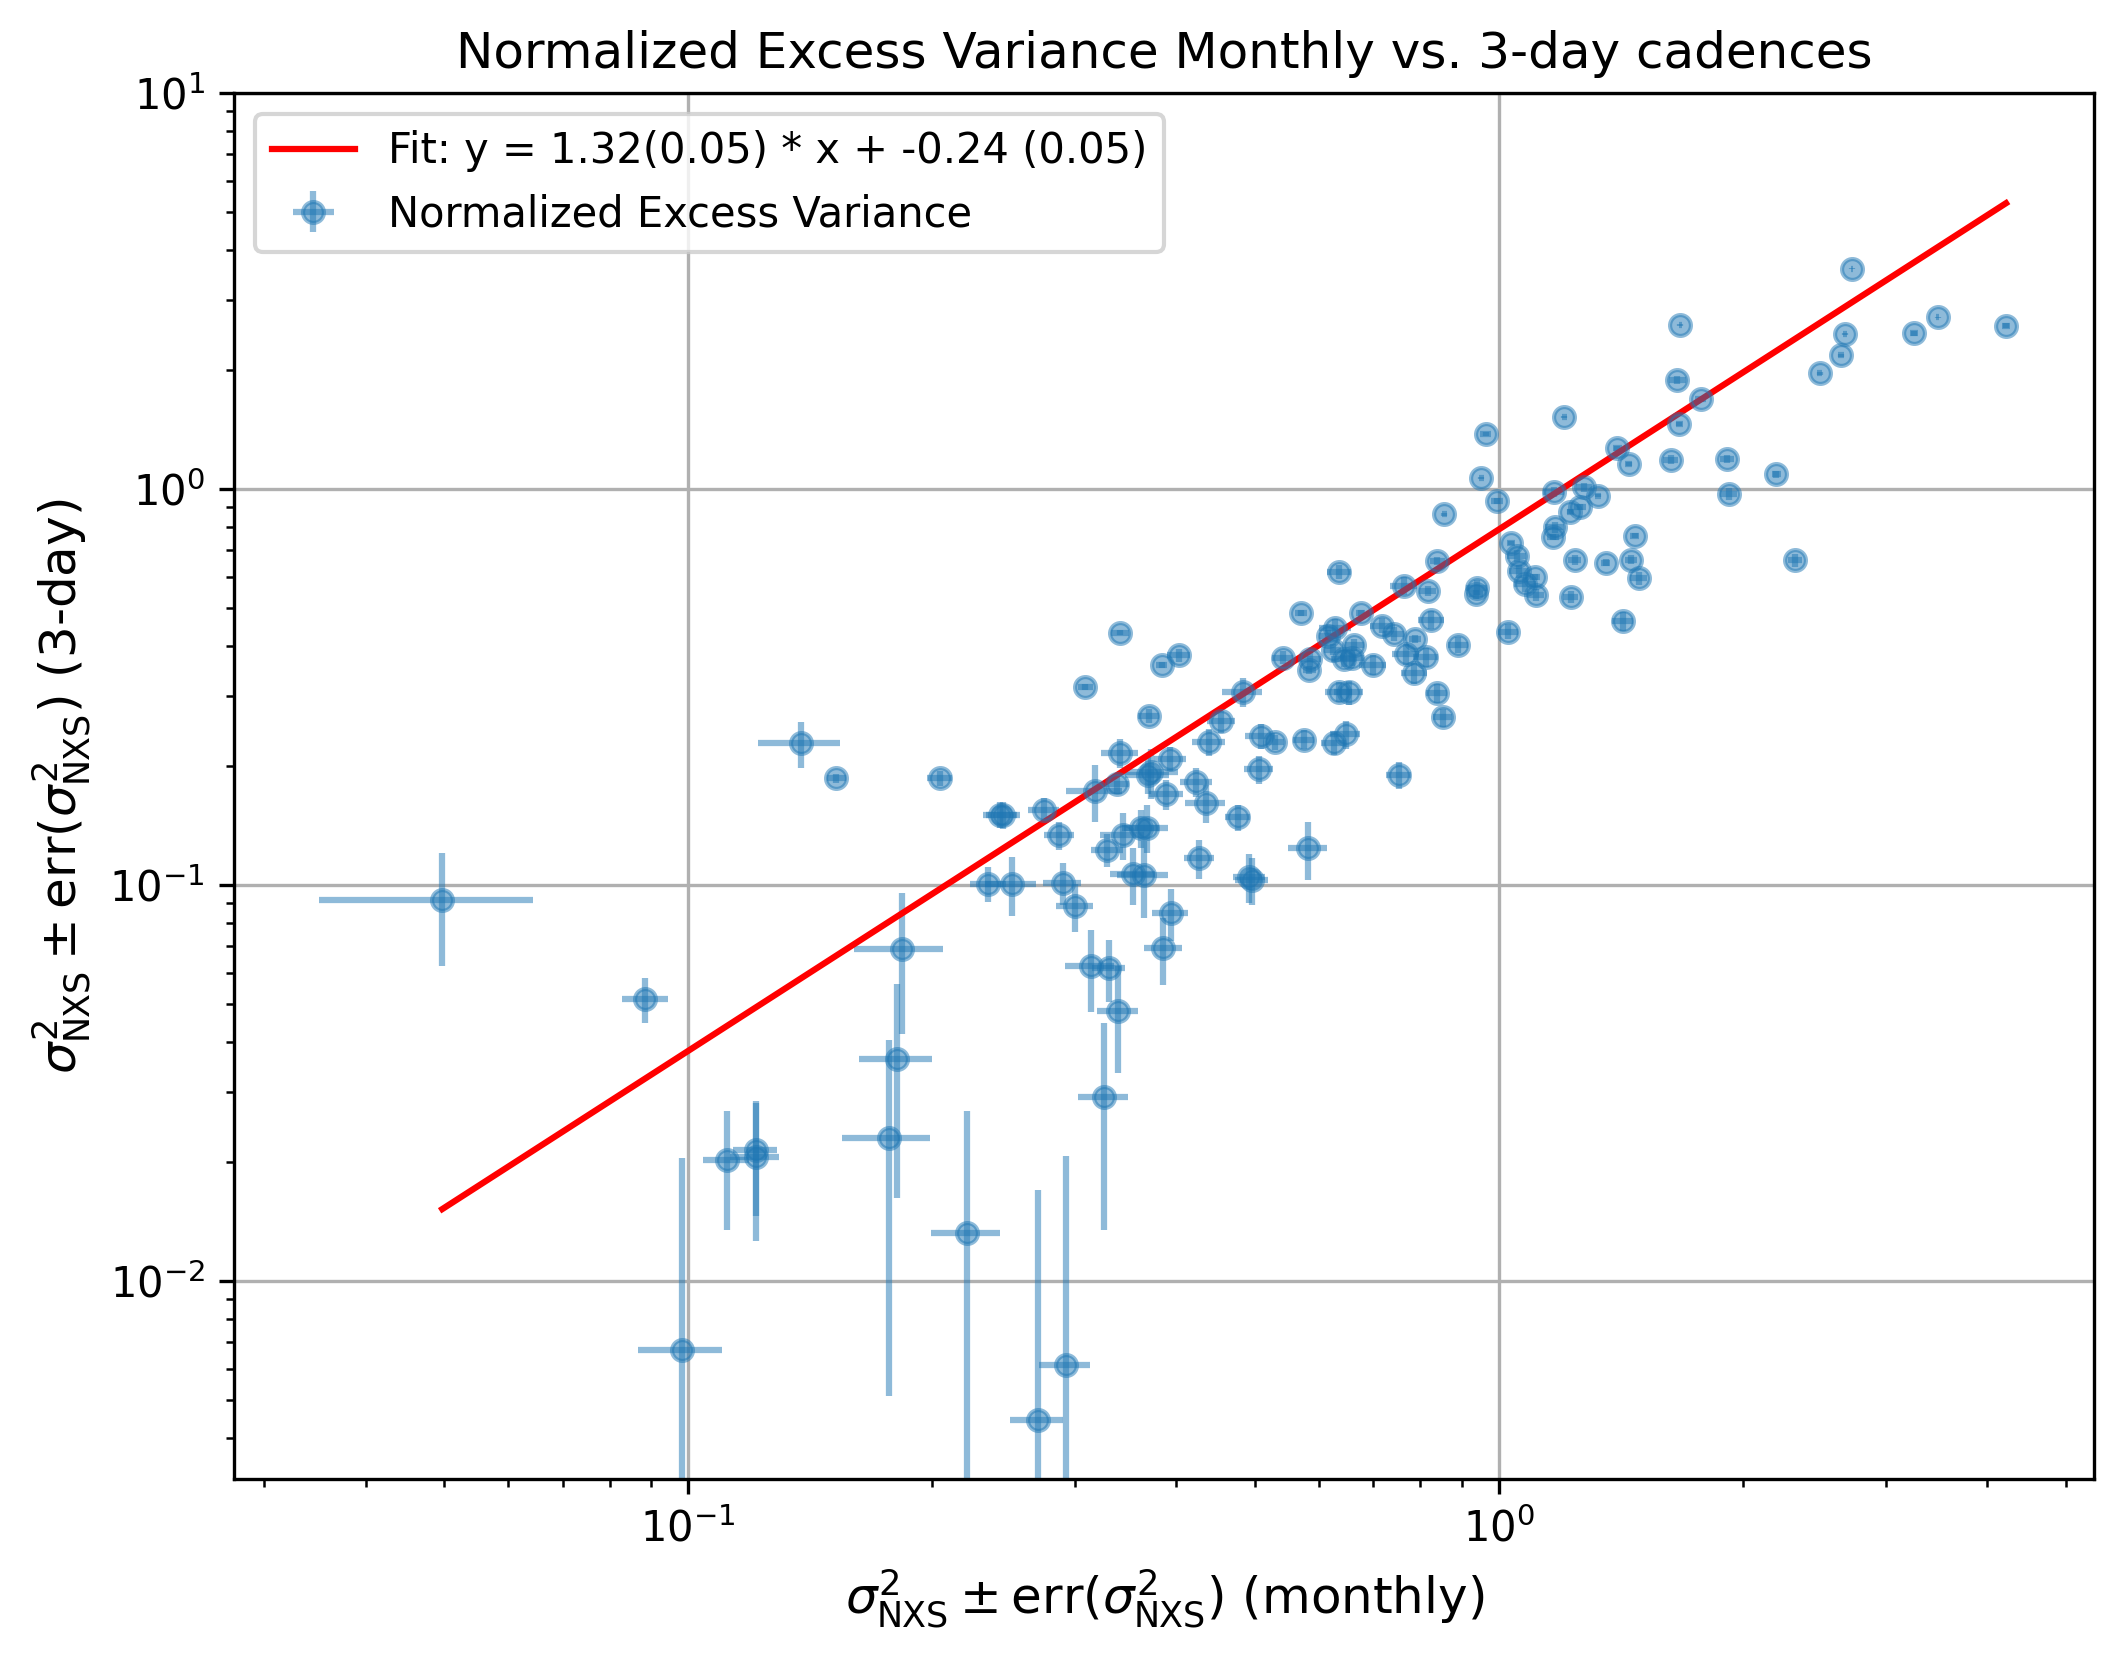

In [64]:
plt.figure(figsize=(8, 6), dpi=300)

# Plotting the data with error bars
plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

# Plotting the regression line
x_fit = np.linspace(min(x), max(x), 100)
log_x_fit = np.log(x_fit)
log_y_fit = slope * log_x_fit + intercept
y_fit = np.exp(log_y_fit)
plt.plot(x_fit, y_fit, color='red', label=f'Fit: y = {slope:.2f}({slope_err:.2f}) * x + {intercept:.2f} ({intercept_err:.2f})')
# plt.plot(x_fit, y_fit, color='purple', label=f'Fit: y = {np.exp(intercept):.2e} * x^{slope:.2f}')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title('Normalized Excess Variance Monthly vs. 3-day cadences', fontsize=12)
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.ylim(10**(-2.5),1e1)

plt.grid(True)
plt.show()

## Selection of sources which show significant variability on a monthly timescale

--> only select sources with $\sigma_{NXS}^{2}$(monthly) - 3*err$[\sigma_{NXS}^{2}]$(monthly) > 0

In [65]:
# selected_indices = []

# for index, row in enumerate(table_agn_pop_4lac_dr3_variability_monthly):
    
#     ## Check if V_NXS and eV_NXS are not NaN
#     if not (row['Norm_Excess_Variance_Estimated'] is None or row['Unc_Norm_Excess_Variance_Estimated'] is None):
        
#         ## 3 sigma criteria
#         if row['Norm_Excess_Variance_Estimated'] - 3 * row['Unc_Norm_Excess_Variance_Estimated'] > 0:
            
#             selected_indices.append(index) # add index to list


# if selected_indices:
    
#     selected_table_monthly = table_agn_pop_4lac_dr3_variability_monthly[selected_indices]
#     selected_table_3days = table_agn_pop_4lac_dr3_variability_3days[selected_indices]
    
#     selected_table_monthly.write('./resulting_catalogs/selected_rows_monthly.ecsv', format='ascii.ecsv', overwrite=True)
#     selected_table_3days.write('./resulting_catalogs/selected_rows_3days.ecsv', format='ascii.ecsv', overwrite=True)

# else:
#     print("No rows satisfy the condition.")


In [66]:
# selected_table_3days

In [67]:
# selected_table_monthly

In [68]:
# ## Mkn 421 == 4FGL J1104.4+3812

# selected_table_monthly[selected_table_monthly['Source_Name'] == 'J1104.4+3812']

In [69]:
# # Mkn 501 == 4FGL J1653.8+3945

# selected_table_monthly[selected_table_monthly['Source_Name'] == 'J1653.8+3945']

In [70]:
# ## PKS 2155-304 == 4FGL J2158.8-3013

# selected_table_monthly[selected_table_monthly['Source_Name'] == 'J2158.8-3013']

In [71]:
# ## PG 1553+113 == 4FGL J1555.7+1111

# selected_table_monthly[selected_table_monthly['Source_Name'] == 'J1555.7+1111']

In [72]:
# ## plot V_NXS(3-day) +/- eV_NXS(3-day) versus V_NXS(month) +/- eV_NXS(month)

# plt.figure(figsize=(5,5), dpi=300)

# plt.errorbar(selected_table_3days['Norm_Excess_Variance_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'],
#              xerr=selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], yerr=selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'],
#              fmt='o', markersize=5, alpha=0.7, label='Normalized Excess Variance')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
# plt.title('Comparison of Excess Variance between 3-day and Monthly Data (log scale)', fontsize=12)
# plt.legend()

# plt.xscale('log')
# plt.yscale('log')

# plt.ylim(plt.xlim())

# plt.grid(True)
# plt.show()

In [73]:
# ## plot V_NXS(3-day) +/- eV_NXS(3-day) versus V_NXS(month) +/- eV_NXS(month)

# plt.figure(figsize=(8,6), dpi=300)

# plt.errorbar(selected_table_3days['Norm_Excess_Variance_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'],
#              xerr=selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], yerr=selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'],
#              fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
# plt.title('Normalized Excess Variance 3-day vs. Monthly cadences', fontsize=12)
# plt.legend()

# plt.xscale('log')
# plt.yscale('log')

# plt.ylim(plt.xlim())

# plt.grid(True)
# plt.show()

In [74]:
# plt.figure(figsize=(8,6), dpi=300)


# sns.scatterplot(x=selected_table_3days['Norm_Excess_Variance_Estimated'], 
#                 y=selected_table_monthly['Norm_Excess_Variance_Estimated'], 
#                 hue=selected_table_monthly['SED_class'], hue_order=['LSP','ISP','HSP'],
#                 style=selected_table_monthly['SED_class'], alpha=0.5)

# plt.errorbar(selected_table_3days['Norm_Excess_Variance_Estimated'], 
#              selected_table_monthly['Norm_Excess_Variance_Estimated'],
#              xerr=selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], 
#              yerr=selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'],
#              fmt='none', ecolor='gray', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}[\sigma_{\mathrm{NXS}}^{2}]$ (3-day binning)', fontsize=10)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}[\sigma_{\mathrm{NXS}}^{2}]$ (monthly binning)', fontsize=10)
# plt.title('Normalized Excess Variance - SED Classes', fontsize=12)
# plt.legend()

# plt.ylim(plt.xlim())

# plt.grid(True)
# plt.show()


In [75]:
# plt.figure(figsize=(8,6), dpi=300)


# sns.scatterplot(x=selected_table_3days['Norm_Excess_Variance_Estimated'], 
#                 y=selected_table_monthly['Norm_Excess_Variance_Estimated'], 
#                 hue=selected_table_monthly['PL_Index'], size=selected_table_monthly['PL_Index'])

# plt.errorbar(selected_table_3days['Norm_Excess_Variance_Estimated'], 
#              selected_table_monthly['Norm_Excess_Variance_Estimated'],
#              xerr=selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], 
#              yerr=selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'],
#              fmt='none', ecolor='gray', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}[\sigma_{\mathrm{NXS}}^{2}]$ (3-day binning)', fontsize=10)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}[\sigma_{\mathrm{NXS}}^{2}]$ (monthly binning)', fontsize=10)
# plt.title('Normalized Excess Variance - PL Index', fontsize=12)
# plt.legend()

# plt.ylim(plt.xlim())

# plt.grid(True)
# plt.show()


NameError: name 'selected_table_3days' is not defined

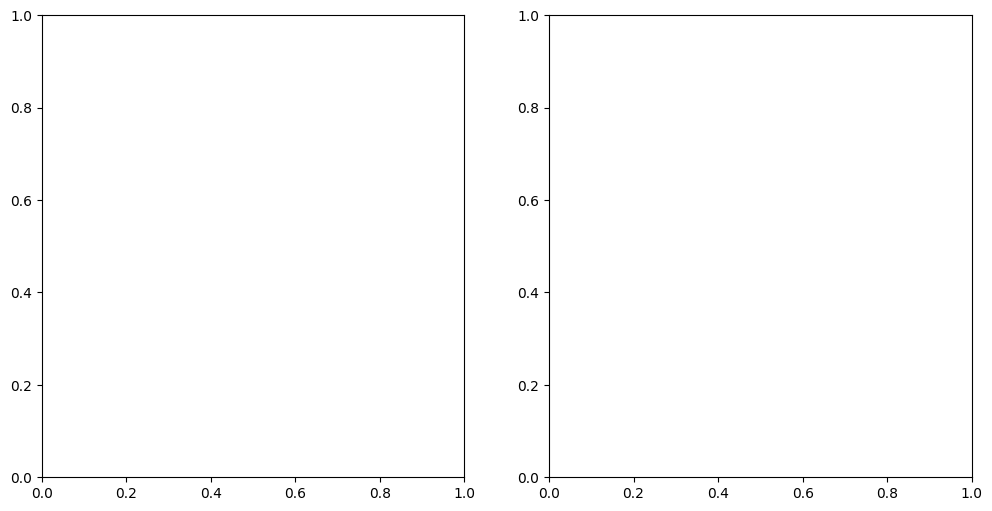

In [76]:
## show the distributions (histograms) of V_NXS(3-day) and V_NXS(month)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.histplot(selected_table_3days['Norm_Excess_Variance_Estimated'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Excess Variance - 3days Distribution')

sns.histplot(selected_table_monthly['Norm_Excess_Variance_Estimated'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Excess Variance - Monthly Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# ## x and y with same values

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

# sns.histplot(selected_table_3days['Norm_Excess_Variance_Estimated'], bins=30, kde=True, ax=axes[0])
# axes[0].set_title('Excess Variance - 3days Distribution')
# axes[0].set_xlim(-1, 20)
# axes[0].set_ylim(0, 150)

# sns.histplot(selected_table_monthly['Norm_Excess_Variance_Estimated'], bins=30, kde=True, ax=axes[1])
# axes[1].set_title('Excess Variance - Monthly Distribution')

# plt.tight_layout()
# plt.show()

In [ ]:
# ## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

# plt.figure(figsize=(8,6), dpi=300)

# plt.errorbar(selected_table_monthly['Norm_Excess_Variance_Estimated'], selected_table_3days['Norm_Excess_Variance_Estimated'],
#              xerr=selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'], yerr=selected_table_3days['Unc_Norm_Excess_Variance_Estimated'],
#              fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
# plt.title('Normalized Excess Variance 3-day vs. Monthly cadences', fontsize=12)
# plt.legend()

# plt.xscale('log')
# plt.yscale('log')

# plt.ylim(10**(-2.5),1e1)
# plt.xlim(plt.ylim())
# # plt.ylim(plt.xlim())

# plt.grid(True)
# plt.show()

In [ ]:
# ## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

# plt.figure(figsize=(8,6), dpi=300)

# plt.errorbar(selected_table_monthly['Norm_Excess_Variance_Estimated'], selected_table_3days['Norm_Excess_Variance_Estimated'],
#              xerr=selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'], yerr=selected_table_3days['Unc_Norm_Excess_Variance_Estimated'],
#              fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
# plt.title('Normalized Excess Variance Monthly vs. 3-day cadences', fontsize=12)
# plt.legend()

# plt.xscale('log')
# plt.yscale('log')

# # plt.xlim(plt.ylim())
# plt.ylim(plt.xlim())

# plt.grid(True)
# plt.show()

In [ ]:
# x = selected_table_monthly['Norm_Excess_Variance_Estimated']
# y = selected_table_3days['Norm_Excess_Variance_Estimated']
# x_err = selected_table_monthly['Unc_Norm_Excess_Variance_Estimated']
# y_err = selected_table_3days['Unc_Norm_Excess_Variance_Estimated']

In [ ]:
# # Log transformation
# log_x = np.log(x)
# log_y = np.log(y)
# log_x_err = x_err / x  # relative error in log scale
# log_y_err = y_err / y  # relative error in log scale

In [ ]:
# def proportional_func(B, x):
#     return B[0]*x # + B[1]

In [ ]:
# import scipy.odr.odrpack as odrpack

# ## create a model
# proportional_model = odrpack.Model(proportional_func)

# ## create data object with uncertainties
# data = odrpack.RealData(log_x, log_y, sx=log_x_err, sy=log_y_err)

# ## perform ODR
# odr = odrpack.ODR(data, proportional_model, beta0=[1.])
# output = odr.run()

# output.pprint()

# ## extract the slope and its uncertainty
# slope = output.beta[0]
# slope_err = output.sd_beta[0]

# print(f"Slope: {slope}")
# print(f"Slope uncertainty: {slope_err}")
# print(f"Residual Variance: {output.res_var}")

In [ ]:
# # Plotting the data with error bars and the best-fit line
# plt.figure(figsize=(8, 6), dpi=300)

# # Plot data points with error bars
# plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', markersize=5, alpha=0.5, label='Data')

# # Plot the best-fit line
# x_fit = np.linspace(min(log_x), max(log_x), 100)
# y_fit = slope * x_fit
# plt.plot(x_fit, y_fit, color='red', label=f'Fit: y = {slope:.2f}x ± {slope_err:.2f}')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2}$ (monthly)', fontsize=12)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2}$ (3-day)', fontsize=12)
# plt.title('Normalized Excess Variance: Monthly vs. 3-day', fontsize=12)
# plt.legend()
# plt.xscale('log')
# plt.yscale('log')
# plt.grid(True)
# plt.show()

In [ ]:
# from scipy.odr import ODR, Model, RealData

# def linear_func(B, x):
#     return B[0] * x + B[1]


# linear_model = Model(linear_func)

# data = RealData(log_x, log_y, sx=log_x_err, sy=log_y_err)

# odr = ODR(data, linear_model, beta0=[1., 2.])

# output = odr.run()

# output.pprint()

# ## extract the slope and its uncertainty
# slope = output.beta[0]
# slope_err = output.sd_beta[0]

# intercept = output.beta[1]
# intercept_err = output.sd_beta[1]

# print(f"Slope: {slope}")
# print(f"Slope uncertainty: {slope_err}")
# print(f"Residual Variance: {output.res_var}")


# print(f"Intercept: {intercept}")
# print(f"Intercept uncertainty: {intercept_err}")


In [ ]:
# np.exp(slope)

In [ ]:
# plt.figure(figsize=(8, 6), dpi=300)

# # Plotting the data with error bars
# plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

# # Plotting the regression line
# x_fit = np.linspace(min(x), max(x), 100)
# log_x_fit = np.log(x_fit)
# log_y_fit = slope * log_x_fit + intercept
# y_fit = np.exp(log_y_fit)
# plt.plot(x_fit, y_fit, color='red', label=f'Fit: y = {slope:.2f}({slope_err:.2f}) * x + {intercept:.2f} ({intercept_err:.2f})')
# # plt.plot(x_fit, y_fit, color='purple', label=f'Fit: y = {np.exp(intercept):.2e} * x^{slope:.2f}')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
# plt.title('Normalized Excess Variance Monthly vs. 3-day cadences', fontsize=12)
# plt.legend()

# plt.xscale('log')
# plt.yscale('log')

# plt.ylim(1e-2, 10)  # Set y-axis limits to be below 10^1

# plt.grid(True)
# plt.show()

In [ ]:
# selected_table_3days_df = selected_table_3days.to_pandas()
# selected_table_monthly_df = selected_table_monthly.to_pandas()

In [ ]:
# def categorize_sources(row, a, b):
#     line_value = np.exp(a * np.log(row['Norm_Excess_Variance_Estimated_monthly']) + b)
#     if row['Norm_Excess_Variance_Estimated_3days'] > 10:
#         return 'red'
#     elif row['Norm_Excess_Variance_Estimated_3days'] > line_value:
#         return 'orange'
#     else:
#         return 'blue'

In [ ]:
# # Example coefficients for the line y = ax + b
# a = 1.8
# b = 1.7

In [ ]:
# # Merge the dataframes to make categorization easier
# merged_df = pd.merge(selected_table_3days_df, selected_table_monthly_df, on='Source_Name', suffixes=('_3days', '_monthly'))

In [ ]:
# # Apply the categorization function
# merged_df['color'] = merged_df.apply(lambda row: categorize_sources(row, a, b), axis=1)

In [ ]:
# merged_df

In [ ]:
# merged_df.to_csv('selected_final_table.csv', index=False)

In [ ]:
# # Merge the dataframes on 'Source_Name'
# merged_final_df = pd.merge(selected_table_3days_df, selected_table_monthly_df, on='Source_Name', suffixes=('_3days', '_monthly'))

In [ ]:
# merged_final_df

In [ ]:
# # Calculate a * sigma²_NXS(monthly)
# merged_final_df['a*sigma²_NXS(monthly)'] = np.exp(slope) * merged_df['Norm_Excess_Variance_Estimated_monthly']

In [ ]:
# # Prepare the final table with all sources
# final_table = df_agn_pop_4lac_dr3[['Source_Name']]

In [ ]:
# # Merge with the calculated values
# final_table = final_table.merge(merged_final_df[['Source_Name', 
#                                            'Norm_Excess_Variance_Estimated_monthly', 
#                                            'Unc_Norm_Excess_Variance_Estimated_monthly', 
#                                            'a*sigma²_NXS(monthly)', 
#                                            'Norm_Excess_Variance_Estimated_3days', 
#                                            'Unc_Norm_Excess_Variance_Estimated_3days']], 
#                                 on='Source_Name', how='left')

In [ ]:
# # Rename columns for clarity
# final_table.rename(columns={
#     'Norm_Excess_Variance_Estimated_monthly': 'sigma²_NXS(month)',
#     'Unc_Norm_Excess_Variance_Estimated_monthly': 'err_sigma²_NXS(month)',
#     'a*sigma²_NXS(monthly)': 'a*sigma²_NXS(month)',
#     'Norm_Excess_Variance_Estimated_3days': 'sigma²_NXS(3 day)',
#     'Unc_Norm_Excess_Variance_Estimated_3days': 'err_sigma²_NXS(3 day)'
# }, inplace=True)

In [ ]:
# Ensure that 'sigma²_NXS(3 day)' and 'err_sigma²_NXS(3 day)' are NaN for sources not passing the cuts
# final_table['sigma²_NXS(3 day)'] = final_table['sigma²_NXS(3 day)'].where(final_table['sigma²_NXS(month)'].notna(), np.nan)
# final_table['err_sigma²_NXS(3 day)'] = final_table['err_sigma²_NXS(3 day)'].where(final_table['sigma²_NXS(month)'].notna(), np.nan)

In [ ]:
# # Save the final table to a CSV file
# final_table.to_csv('final_table.csv', index=False)

In [ ]:
# final_table

In [ ]:
# plt.figure(figsize=(8, 6), dpi=300)

# for color in ['red', 'blue', 'orange']:
#     subset = merged_df[merged_df['color'] == color]
#     plt.errorbar(subset['Norm_Excess_Variance_Estimated_monthly'], subset['Norm_Excess_Variance_Estimated_3days'],
#                  xerr=subset['Unc_Norm_Excess_Variance_Estimated_monthly'], yerr=subset['Unc_Norm_Excess_Variance_Estimated_3days'],
#                  fmt='o', markersize=5, alpha=0.5, label=f'{color.capitalize()} Sources', color=color)

# # Plotting the regression line
# x_fit = np.linspace(min(merged_df['Norm_Excess_Variance_Estimated_monthly']), max(merged_df['Norm_Excess_Variance_Estimated_monthly']), 100)
# log_x_fit = np.log(x_fit)
# log_y_fit = a * log_x_fit + b
# y_fit = np.exp(log_y_fit)
# plt.plot(x_fit, y_fit, color='red', label=f'2nd Cut: y = {np.exp(b):.2e} * x^{a:.2f}')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
# plt.title('Normalized Excess Variance Monthly vs. 3-day cadences', fontsize=12)
# plt.legend()

# plt.xscale('log')
# plt.yscale('log')

# plt.xlim(plt.ylim())

# plt.grid(True)
# plt.show()


In [ ]:
# red_sources = merged_df[merged_df['color'] == 'red']['Source_Name'].tolist()
# blue_sources = merged_df[merged_df['color'] == 'blue']['Source_Name'].tolist()
# orange_sources = merged_df[merged_df['color'] == 'orange']['Source_Name'].tolist()

In [ ]:
# len(red_sources)

In [ ]:
# red_sources

In [ ]:
# orange_sources

In [ ]:
# blue_sources_df = merged_df[merged_df['color'] == 'blue']

In [ ]:
# # Check for the presence of each specified source in the blue sources
# source_names = ['J1104.4+3812', 'J1653.8+3945', 'J2158.8-3013', 'J1555.7+1111']

In [ ]:
# for source_name in source_names:
#     is_in_blue = source_name in blue_sources_df['Source_Name'].values
#     print(f"Source {source_name} is in blue sources: {is_in_blue}")

#     # # If needed, you can also display the details of the source
#     # if is_in_blue:
#     #     print(blue_sources_df[blue_sources_df['Source_Name'] == source_name])

In [ ]:
# orange_sources

In [ ]:
# for i in orange_sources:
#     analyzer = JSONAnalyzer(f'4FGL+{i}.json','3-days','fixed')
    
#     source_dictionary = analyzer.data_dict
#     source_df = analyzer.create_dataframe()

#     filtered_df = analyzer.removing_outliers()

#     ## reset index
#     filtered_df.reset_index(inplace=True)
    
#     ## select only non-NaN values from the DataFrame for flux and flux_error
#     non_nan_values = filtered_df.dropna(subset=['flux'])

#     ## get the indexes (time) of the non-NaN values
#     time_fit_non_nan = non_nan_values['time_fit_convergence'].values

#     ## selected flux points
#     selected_flux_values = non_nan_values['flux'].values
#     selected_flux_error_values = non_nan_values['flux_error'].values
#     selected_ts_values = non_nan_values['values_ts'].values
    
#     ## spectrum flux (?)
#     index = df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['Source_Name'] == source_name].index[0]
#     spectrum_flux = df_agn_pop_4lac_dr3.loc[index, 'Spectrum_Flux_Estimated']
    
#     analyzer.plot_lc(2e-6,spectrum_flux)

In [ ]:
## 3-days

x_axis_all = []
y_axis_all = []


for file_name in filtered_3days_file_list:
    
    analyzer = JSONAnalyzer(file_name,'3-days','fixed')

    source_dictionary = analyzer.data_dict
    source_df = analyzer.create_dataframe()

    filtered_df = analyzer.removing_outliers()
    
    ## select only non-NaN values from the DataFrame for flux and flux_error
    flux_non_nan_values = filtered_df.dropna(subset=['flux'])
    flux_error_non_nan_values = filtered_df.dropna(subset=['flux_error'])

    ## get the indexes (time) of the non-NaN values
    time_flux_non_nan = flux_non_nan_values.index
    time_flux_error_non_nan = flux_error_non_nan_values.index

    ## selected flux points
    selected_flux_values = flux_non_nan_values['flux']
    selected_flux_error_values = flux_error_non_nan_values['flux_error']

    x_axis = selected_flux_values / (selected_flux_error_values**2)
    y_axis = selected_flux_values / np.median(selected_flux_values)
    
    ## append
    x_axis_all.extend(x_axis)
    y_axis_all.extend(y_axis)

    
## Plot
plt.figure(figsize=(8, 7))
plt.scatter(x_axis_all, y_axis_all, alpha=0.5, s=50, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2,1e12)
plt.xlabel('phi / sigma^2')
plt.ylabel('phi / phi_median')
plt.title('Normalized Flux vs Flux/Median Flux')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
## 3-days -- flux_error / flux vs. ts

x_axis_all3 = []
y_axis_all3 = []


for file_name in filtered_3days_file_list:
    
    analyzer = JSONAnalyzer(file_name,'3-days','fixed')

    source_dictionary = analyzer.data_dict
    source_df = analyzer.create_dataframe()

    filtered_df = analyzer.removing_outliers()
#     filtered_df = source_df

    ## reset index
    filtered_df.reset_index(inplace=True)
    
    ## select only non-NaN values from the DataFrame for flux and flux_error
    non_nan_values = filtered_df.dropna(subset=['flux'])
    
#     print(filtered_df)


    ## get the indexes (time) of the non-NaN values
    time_fit_non_nan = non_nan_values['time_fit_convergence'].values

    ## selected flux points
    selected_flux_values = non_nan_values['flux'].values
    selected_flux_error_values = non_nan_values['flux_error'].values
    selected_ts_values = non_nan_values['values_ts'].values
    
#     print(selected_ts_values)

    x_axis = selected_ts_values
    y_axis = selected_flux_error_values / selected_flux_values
#     x_axis = selected_flux_values / selected_flux_error_values
    
    ## append
    x_axis_all3.extend(x_axis)
    y_axis_all3.extend(y_axis)


In [ ]:
x_axis_all3_array = np.array(x_axis_all3)
y_axis_all3_array = np.array(y_axis_all3)

In [ ]:
## Plot TS

plt.figure(figsize=(8, 7))
plt.scatter(1/np.sqrt(x_axis_all3_array), y_axis_all3_array, alpha=0.5, s=50, color='green')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('1 / sqrt(TS)', fontsize=12)
plt.ylabel('flux_error / flux', fontsize=12)
plt.title('Test Statistics Correlation with Flux and flux_error', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()